# Cross-Domain Neural Networks for JPEG Decompression (ImageNet)

This Jupyter Notebook trains U-net and W-net models for JPEG decompression.

<a href=#networka>Network A</a>: Image-domain U-net

<a href=#networkb>Network B</a>: DCT-domain U-net (apply DCT on 8x8 blocks of the image) 

<a href=#networkc>Network C</a>: DCT-Image-domain W-net (end-to-end cascade)

<a href=#networkc2>Network C2</a>: Pseudo DCT-Image-domain W-net (use the results from Network B to train Network A) 

<a href=#networkd>Network D</a>: Image-Image-domain W-net

<a href=#networke>Network E</a>: DCT-DCT-domain W-net (apply DCT on 8x8 blocks of the image)

<a href=#scratchpad>Scratchpad</a>: Testing things

<a href=#networkf>Network F</a>: DFT-Image-domain W-net (end-to-end cascade)

<a href=#networkg>Network G</a>: Fully-Connected Network

<a href=#networkh>Network H</a>: Cascade of FC and U-nets

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20
- Dropout

In [1]:
#%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
#from cs_models import deep_cascade_unet_no_dc, deep_cascade_unet, deep_cascade_unet_ksp_no_dc, \
#dequantization_network, deep_cascade_fc_unet
from dctools import py_dct2d, py_idct2d, dct_in_blocks, idct_in_blocks, get_quantization_matrix, \
extract_image_patches, compile_image_patches

Using TensorFlow backend.


In [2]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Lambda, Add, Subtract, LeakyReLU, \
                         MaxPooling2D, concatenate, UpSampling2D,\
                         Multiply, Dense, Flatten, Reshape


def tf_dct2d(im):
    return K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im,type=2,axis=-1,norm='ortho'),perm=[0,2,1,3]),type=2,axis=-1,norm='ortho'),perm=[0,2,1,3])
    
    
def tf_idct2d(mat): 
    return K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(mat,type=2,axis=-1,norm='ortho'),perm=[0,2,1,3]),type=2,axis=-1,norm='ortho'),perm=[0,2,1,3])


# Modified from:
# https://www.programcreek.com/python/example/90422/tensorflow.extract_image_patches
def extract_patches(x):
    patches = K.tf.extract_image_patches(
        x,
        (1, 8, 8, 1),
        (1, 8, 8, 1),
        (1, 1, 1, 1),
        padding="SAME"
    )
    patches_shape = K.tf.shape(patches)
    return K.tf.reshape(patches, 
                      [K.tf.reduce_prod(patches_shape[0:3]), 
                       8, 8, 1])  # returns [batch_patches, h, w, c] 


# x = orig
# y = orig in patches
def extract_patches_inverse(x, y):
    _x = K.tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = K.tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return K.tf.gradients(_y, _x, grad_ys=y)[0] / grad


def dct_layer(image):
    """
    Input: single channel array representing image domain data
    Output: single channel array representing dct coefficient data
    """
    
    patches = extract_patches(image)
    dct_patches = tf_dct2d(patches)
    #dct_image = extract_patches_inverse(image, dct_patches)
    
    return dct_patches


def idct_layer(data_list):
    """
    Input: a list of input data. See below
    Output: single channel array representing image domain data
    
    data_list: data_list[0] = dct matrix (in patches) [total_num_patches, patch_size, patch_size, chnl]
               data_list[1] = single channel image in original dimensions [batch, H, W, chnl]
    """
    
    #patches = extract_patches(dctdata)
    image_patches = tf_idct2d(data_list[0])
    image = extract_patches_inverse(data_list[1], image_patches)
    
    return image


def dct_dc_layer(data_list): #, dctmat, jpeg_dctmat, qmat):
    """
    param data_list: data_list[0] = dct matrix; 
                     data_list[1] = jpeg-compressed dct matrix; 
                     data_list[2] = quantization matrix
    
    
    param dctmat: quantization matrix for each image
    param jpeg_dctmat: single channel array representing dct coefficient data
    param qmat: quantization matrix
    Output: dct coefficients restricted to range
    """
    # Clip range: X_recon = [(X_jpeg*Q - Q/2), (X_jpeg*Q + Q/2)]

    clip_low = Subtract()([data_list[1], data_list[2] * 0.5])
    clip_high = Add()([data_list[1], data_list[2] * 0.5])
    return K.tf.clip_by_value(data_list[0], clip_low, clip_high)

    #return K.tf.clip_by_value(dctmat, clip_low, clip_high)
    

def fft_layer(image):
    """
    Input: 2-channel array representing image domain complex data
    Output: 2-channel array representing k-space complex data
    """

    # get real and imaginary portions
    real = Lambda(lambda image: image[:, :, :, 0])(image)
    imag = Lambda(lambda image: image[:, :, :, 1])(image)

    image_complex = K.tf.complex(real, imag)  # Make complex-valued tensor
    kspace_complex = K.tf.fft2d(image_complex)

    # expand channels to tensorflow/keras format
    real = K.tf.expand_dims(K.tf.real(kspace_complex), -1)
    imag = K.tf.expand_dims(K.tf.imag(kspace_complex), -1)

    # generate 2-channel representation of k-space
    kspace = K.tf.concat([real, imag], -1)
    
    return kspace


def ifft_layer(kspace_2channel):
    """
    Input: 2-channel array representing k-space
    Output: 2-channel array representing image domain
    """
    #get real and imaginary portions
    real = Lambda(lambda kspace_2channel : kspace_2channel[:,:,:,0])(kspace_2channel)
    imag = Lambda(lambda kspace_2channel : kspace_2channel[:,:,:,1])(kspace_2channel)
    
    kspace_complex = K.tf.complex(real,imag) # Make complex-valued tensor
    image_complex = K.tf.ifft2d(kspace_complex)
    
    # expand channels to tensorflow/keras format
    real = K.tf.expand_dims(K.tf.real(image_complex),-1)
    imag = K.tf.expand_dims(K.tf.imag(image_complex),-1)
    
    # generate 2-channel representation of image domain
    image_complex_2channel = K.tf.concat([real, imag], -1)
    return image_complex_2channel


def rfft_layer(image):
    """
    Input: single-channel array representing image domain real data
    Output: 2-channel array representing k-space complex data
    """

    empty = K.tf.zeros_like(image)
    image_complex = K.tf.complex(image,empty)
    
    kspace_complex = K.tf.signal.fft2d(image_complex)
    
    real = K.tf.real(kspace_complex)
    imag = K.tf.imag(kspace_complex)

    # generate 2-channel representation of k-space
    kspace = K.tf.concat([real, imag], -1)

    return kspace


def abs_layer(complex_data):
    """
    Input: 2-channel array representing complex data
    Output: 1-channel array representing magnitude of complex data
    """
    #get real and imaginary portions
    real = Lambda(lambda complex_data : complex_data[:,:,:,0])(complex_data)
    imag = Lambda(lambda complex_data : complex_data[:,:,:,1])(complex_data)
    
    mag = K.tf.abs(K.tf.complex(real,imag))
    mag = K.tf.expand_dims(mag, -1)
    return mag


def fc_dct_layer(image):
    """
    Input: single channel array representing image domain data
    Output: single channel array representing dct coefficient data (in patches)
    """
    
    patches = extract_patches(image)
    dct_patches = tf_dct2d(patches)
    
    return dct_patches


def fc_idct_layer(data_list):
    """
    Input: single channel array representing dct coefficient data (in patches)
    Output: single channel array representing image domain data
    
    data_list: data_list[0] = dct matrix (in patches) [total_num_patches, patch_size, patch_size, chnl]
               data_list[1] = single channel image in original dimensions [batch, H, W, chnl]
    """
    
    image_patches = tf_idct2d(data_list[0])
    image = extract_patches_inverse(data_list[1], image_patches)
    
    return image

def dense_block(dense_input):
    
    inputs_flat = Flatten()(dense_input)
    
    dense1 = Dense(64, input_shape=(64,), activation='tanh')(inputs_flat)
    dense2 = Dense(64, activation='tanh')(dense1)
    dense3 = Dense(128, activation='tanh')(dense2)
    dense4 = Dense(128, activation='tanh')(dense3)
    dense5 = Dense(256, activation='tanh')(dense4)
    dense6 = Dense(256, activation='tanh')(dense5)
    dense7 = Dense(128, activation='tanh')(dense6)
    dense8 = Dense(128, activation='tanh')(dense7)
    dense9 = Dense(64, activation='tanh')(dense8)
    last_dense = Dense(64, activation='tanh')(dense9)

    #output_layer = Reshape(8,8)(dense4)
    output_layer = Reshape((8,8,1), input_shape=(64,))(last_dense)
    
    return output_layer


def unet_block(unet_input, kshape=(3, 3)):
    """
    :param unet_input: Input layer
    :param kshape: Kernel size
    :return: single channel
    """

    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(unet_input)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(up1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(up2)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(up3)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, (1, 1), activation='linear')(conv7)
    out = Add()([conv8, unet_input])
    return out


def unet_block_2chnl(unet_input, kshape=(3, 3)):
    """
    :param unet_input: Input layer
    :param kshape: Kernel size
    :return: 2-channel, complex reconstruction
    """

    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(unet_input)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(up1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(up2)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(up3)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)

    conv8 = Conv2D(2, (1, 1), activation='linear')(conv7)
    out = Add()([conv8, unet_input])
    return out


# NEED TO FIX:
# Don't append iDCT layer for cases like 'ff'
def deep_cascade_fc_unet(depth_str='fi', H=256, W=256, kshape=(3, 3)):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
    qmat = Lambda(extract_patches)(qmat)
    inputs_pat = Lambda(extract_patches)(inputs)
    layers = [inputs]
    fc_flag = False # flag whether input is in the image domain (false) or dct domain (true)
                    # i.e. input is in image domain
    
    for (jj,ii) in enumerate(depth_str):
        print(jj,ii)
        if ii == 'f':
            if not fc_flag: # image domain
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append DCT layer (patches)")
                layers.append(dense_block(layers[-1]))
                print("Append FC/dense block")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat]))
                print("Append data consistency block")
                fc_flag = True
            else: # DCT domain
                layers.append(dense_block(layers[-1]))
                print("Append FC/dense block")
        elif ii == 'i':
            if not fc_flag: # image domain
                layers.append(unet_block(layers[-1], kshape))
                print("Append U-net block")
                fc_flag = False
            else: # DCT domain
                layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
                print("Append iDCT layer (patches)")
                layers.append(unet_block(layers[-1], kshape))
                print("Append U-net block")
                fc_flag = False
        else:
            print("Layer not recognized. Only 'f' and 'i' layers are currently supported.")
            break;
            
        if not ((jj + 1) % len(depth_str) > 0) and ii == 'f' and fc_flag:
            layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
            print("Append iDCT layer (patches)")

    model = Model(inputs=[inputs,qmat], outputs=layers[-1])
    return model


def deep_cascade_fc_unet_no_dc(depth_str='fi', H=256, W=256, kshape=(3, 3)):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    layers = [inputs]
    fc_flag = False # flag whether input is in the image domain (false) or dct domain (true)
                    # i.e. input is in image domain
    
    for (jj,ii) in enumerate(depth_str):
        print(jj,ii)
        if ii == 'f':
            if not fc_flag: # image domain
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append DCT layer (patches)")
                layers.append(dense_block(layers[-1]))
                print("Append FC/dense block")
                fc_flag = True
            else: # DCT domain
                layers.append(dense_block(layers[-1]))
                print("Append FC/dense block")
        elif ii == 'i':
            if not fc_flag: # image domain
                layers.append(unet_block(layers[-1], kshape))
                print("Append U-net block")
                fc_flag = False
            else: # DCT domain
                layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
                print("Append iDCT layer (patches)")
                layers.append(unet_block(layers[-1], kshape))
                print("Append U-net block")
                fc_flag = False
        else:
            print("Layer not recognized. Only 'f' and 'i' layers are currently supported.")
            break;
            
        if not ((jj + 1) % len(depth_str) > 0) and ii == 'f' and fc_flag:
            layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
            print("Append iDCT layer (patches)")

    model = Model(inputs=inputs, outputs=layers[-1])
    return model


def deep_cascade_unet_ksp_no_dc(depth_str='ki', H=256, W=256, kshape=(3, 3)):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model ######
    """

    channels = 2  # inputs are represented as two-channel images (complex)
    inputs = Input(shape=(H, W, channels))
    layers = [inputs]
    kspace_flag = False # flag whether input is in the image domain (false) or frequency domain (true)

    for (jj,ii) in enumerate(depth_str):
        print(jj, ii)
        if ii == 'k' and not kspace_flag:
            # Add a frequency U-net; Input should be in image domain
            layers.append(Lambda(fft_layer)(layers[-1])) 
            print("Append FFT layer")
            kspace_flag = True
        elif ii != 'k' and ii != 'i':
            print("Layer not recognized. Only 'k' and 'i' layers are currently supported.")
            break;

        # Add CNN block
        layers.append(unet_block_2chnl(layers[-1], kshape))
        print("Append U-net block")

        if kspace_flag:
            if (jj + 1) % len(depth_str) > 0: # check if there is a next element
                if depth_str[jj + 1] == 'k':
                    print("FFT layer again. Don't append iFFT layer.")
                else:
                    layers.append(Lambda(ifft_layer)(layers[-1]))
                    layers.append(Lambda(abs_layer)(layers[-1]))
                    print("Append iFFT layer")
                    print("Append magnitude layer")
                    layers.append(Lambda(concat_empty_channel)(layers[-1]))
                    kspace_flag = False
            else:
                layers.append(Lambda(ifft_layer)(layers[-1]))
                layers.append(Lambda(abs_layer)(layers[-1]))
                print("Append iFFT layer")
                print("Append magnitude layer")
                layers.append(Lambda(concat_empty_channel)(layers[-1]))
                kspace_flag = False

    model = Model(inputs=inputs, outputs=layers[-1])
    return model


def deep_cascade_unet_rksp_no_dc(depth_str='ki', H=256, W=256, kshape=(3, 3)):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model ######
    """

    channels = 1  # Real input image
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
    layers = [inputs]
    kspace_flag = False # flag whether input is in the image domain (false) or frequency domain (true)

    for (jj,ii) in enumerate(depth_str):
        print(jj, ii)
        if ii == 'k' and not kspace_flag:
            # Add a frequency U-net; Input should be in image domain
            layers.append(Lambda(rfft_layer)(layers[-1]))
            print("Append rFFT layer")
            kspace_flag = True
        elif ii != 'k' and ii != 'i':
            print("Layer not recognized. Only 'k' and 'i' layers are currently supported.")
            break;

        # Add CNN block
        layers.append(unet_block(layers[-1], kshape))
        print("Append U-net (single-channel) block")

        if kspace_flag:
            if (jj + 1) % len(depth_str) > 0: # check if there is a next element
                if depth_str[jj + 1] == 'k':
                    print("FFT layer again. Don't append iFFT layer.")
                else:
                    layers.append(Lambda(irfft_layer)(layers[-1], inputs))
                    #layers.append(Lambda(abs_layer)(layers[-1]))
                    print("Append irFFT layer")
                    #print("Append magnitude layer")
                    #layers.append(Lambda(concat_empty_channel)(layers[-1]))
                    kspace_flag = False
            else:
                layers.append(Lambda(irfft_layer)(layers[-1], inputs))
                #layers.append(Lambda(abs_layer)(layers[-1]))
                print("Append irFFT layer")
                #print("Append magnitude layer")
                #layers.append(Lambda(concat_empty_channel)(layers[-1]))
                kspace_flag = False

    model = Model(inputs=inputs, outputs=layers[-1])
    return model


def deep_cascade_unet_rksp(depth_str='ki', H=256, W=256, kshape=(3, 3)):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model ######
    """

    channels = 1  # Real input image
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
        
    inputs_patches = Lambda(extract_patches)(inputs)
    qmat_patches = Lambda(extract_patches)(qmat)
    
    layers = [inputs]
    kspace_flag = False # flag whether input is in the image domain (false) or frequency domain (true)

    for (jj,ii) in enumerate(depth_str):
        print(jj, ii)
        if ii == 'k' and not kspace_flag:
            # Add a frequency U-net; Input should be in image domain
            layers.append(Lambda(rfft_layer)(layers[-1]))
            print("Append rFFT layer")
            kspace_flag = True
            # Add CNN block
            layers.append(unet_block_2chnl(layers[-1], kshape))
            print("Append U-net (2-channel) block")
        elif ii == 'i' and not kspace_flag:
            # Add CNN block
            layers.append(unet_block(layers[-1], kshape))
            print("Append U-net (single-channel) block")
        elif ii != 'k' and ii != 'i':
            print("Layer not recognized. Only 'k' and 'i' layers are currently supported.")
            break;
            

        if kspace_flag:
            layers.append(Lambda(ifft_layer)(layers[-1]))
            print("Append iFFT layer")
            intermed = Lambda(abs_layer)(layers[-1])
            layers.append(intermed)
            print("Append magnitude layer")
            kspace_flag = False
            
        print("Append data consistency layer (DCT-DC-iDCT)")
        layers.append(Lambda(dct_layer)(layers[-1])) 
        layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_patches, qmat_patches]))
        layers.append(Lambda(idct_layer)([layers[-1], inputs]))

    model = Model(inputs=[inputs,qmat], outputs=[layers[-1],intermed])
    return model
    

# =============================================================
<a name='networkh'/>

# Network H: Cascades of FC and U-nets

In [3]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

48624
Train set size: 30000
Validation set size: 15000
Test set size: 3624


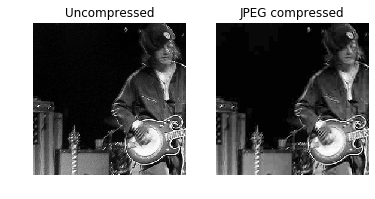

In [4]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [5]:
H,W = 256, 256
norm = 128.0
compr_range = (10,20)

useDC = False

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
#val_qmat = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
    #val_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
        
val_unc -= norm
val_unc /= norm

val_compr -= norm
val_compr /= norm

#val_qmat /= 255.0

(15000, 256, 256, 1)
-1.0 0.9921875 0.17064309
-1.0 0.9921875 0.17066574


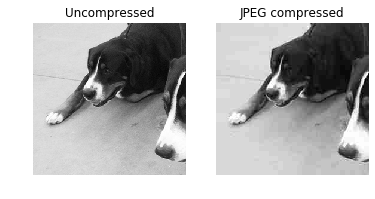

In [6]:
nn = 5910

print(val_unc.shape)
print(val_unc[nn,:,:,0].min(),val_unc[nn,:,:,0].max(), val_unc[nn,:,:,0].mean())
print(val_compr[nn,:,:,0].min(),val_compr[nn,:,:,0].max(), val_compr[nn,:,:,0].mean())

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(val_unc[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(val_compr[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [7]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?
batch_size = 8
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

#train_qmat = np.zeros((len(train_images),H,W,1),dtype = np.float32)

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator_no_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield((batch_comp - norm)/norm, (batch_unc-norm)/norm)
        
def combine_generator_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            train_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
            
        #yield([(batch_comp - 128.0)/128.0, train_qmat/255.0], (batch_unc-128.0)/128.0)
        yield([(batch_comp - 128.0), train_qmat], (batch_unc-128.0))

# combine generators into one which yields image and masks
if useDC:
    combined = combine_generator_dc(image_generator1,compr_range)
else:
    combined = combine_generator_no_dc(image_generator1,compr_range)

(8, 256, 256, 1)
-1.0 0.9921875 -0.06354782
-1.0 0.9921875 -0.0603878


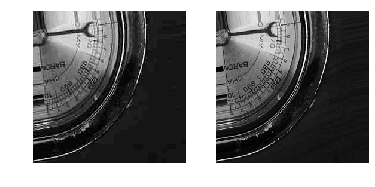

In [8]:
# sample data augmentation
if useDC:
    for ii in combined:
        print(ii[0][0].shape)
        print(ii[0][0].min(),ii[0][0].max(), ii[0][0].mean())
        print(ii[1].min(),ii[1].max(), ii[1].mean())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break
else:
    for ii in combined:
        print(ii[0].shape)
        print(ii[0].min(),ii[0].max(), ii[0].mean())
        print(ii[1].min(),ii[1].max(), ii[1].mean())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break

# F Fully-Connected Network - this is a check to see if our TF and python implementations are equivalent 

In [9]:
epochs = 100
batch_size= 8
model_name = "../Models/20190610-imagenet-fc_unet_cascade_fi_tf_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=5, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_fc_unet(depth_str='fi')
model.compile(loss = "mse",optimizer=opt)

Instructions for updating:
Colocations handled automatically by placer.
0 f
Instructions for updating:
Use tf.cast instead.
Append DCT layer (patches)
Append FC/dense block
1 i
Append iDCT layer (patches)
Append U-net block


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 8, 8, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 64)           0           lambda_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (D

In [11]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

No Data Consistency
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3750/3750 [==============================] - 420s 112ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 2/100
3750/3750 [==============================] - 415s 111ms/step - loss: 0.0042 - val_loss: 0.0071
Epoch 3/100
3750/3750 [==============================] - 413s 110ms/step - loss: 0.0050 - val_loss: 0.0080
Epoch 4/100
3750/3750 [==============================] - 411s 110ms/step - loss: 0.0043 - val_loss: 0.0073
Epoch 5/100
3750/3750 [==============================] - 410s 109ms/step - loss: 0.0043 - val_loss: 0.0080
Epoch 6/100
3750/3750 [==============================] - 411s 109ms/step - loss: 0.0039 - val_loss: 0.0085
Epoch 7/100
3750/3750 [==============================] - 412s 110ms/step - loss: 0.0038 - val_loss: 0.0074


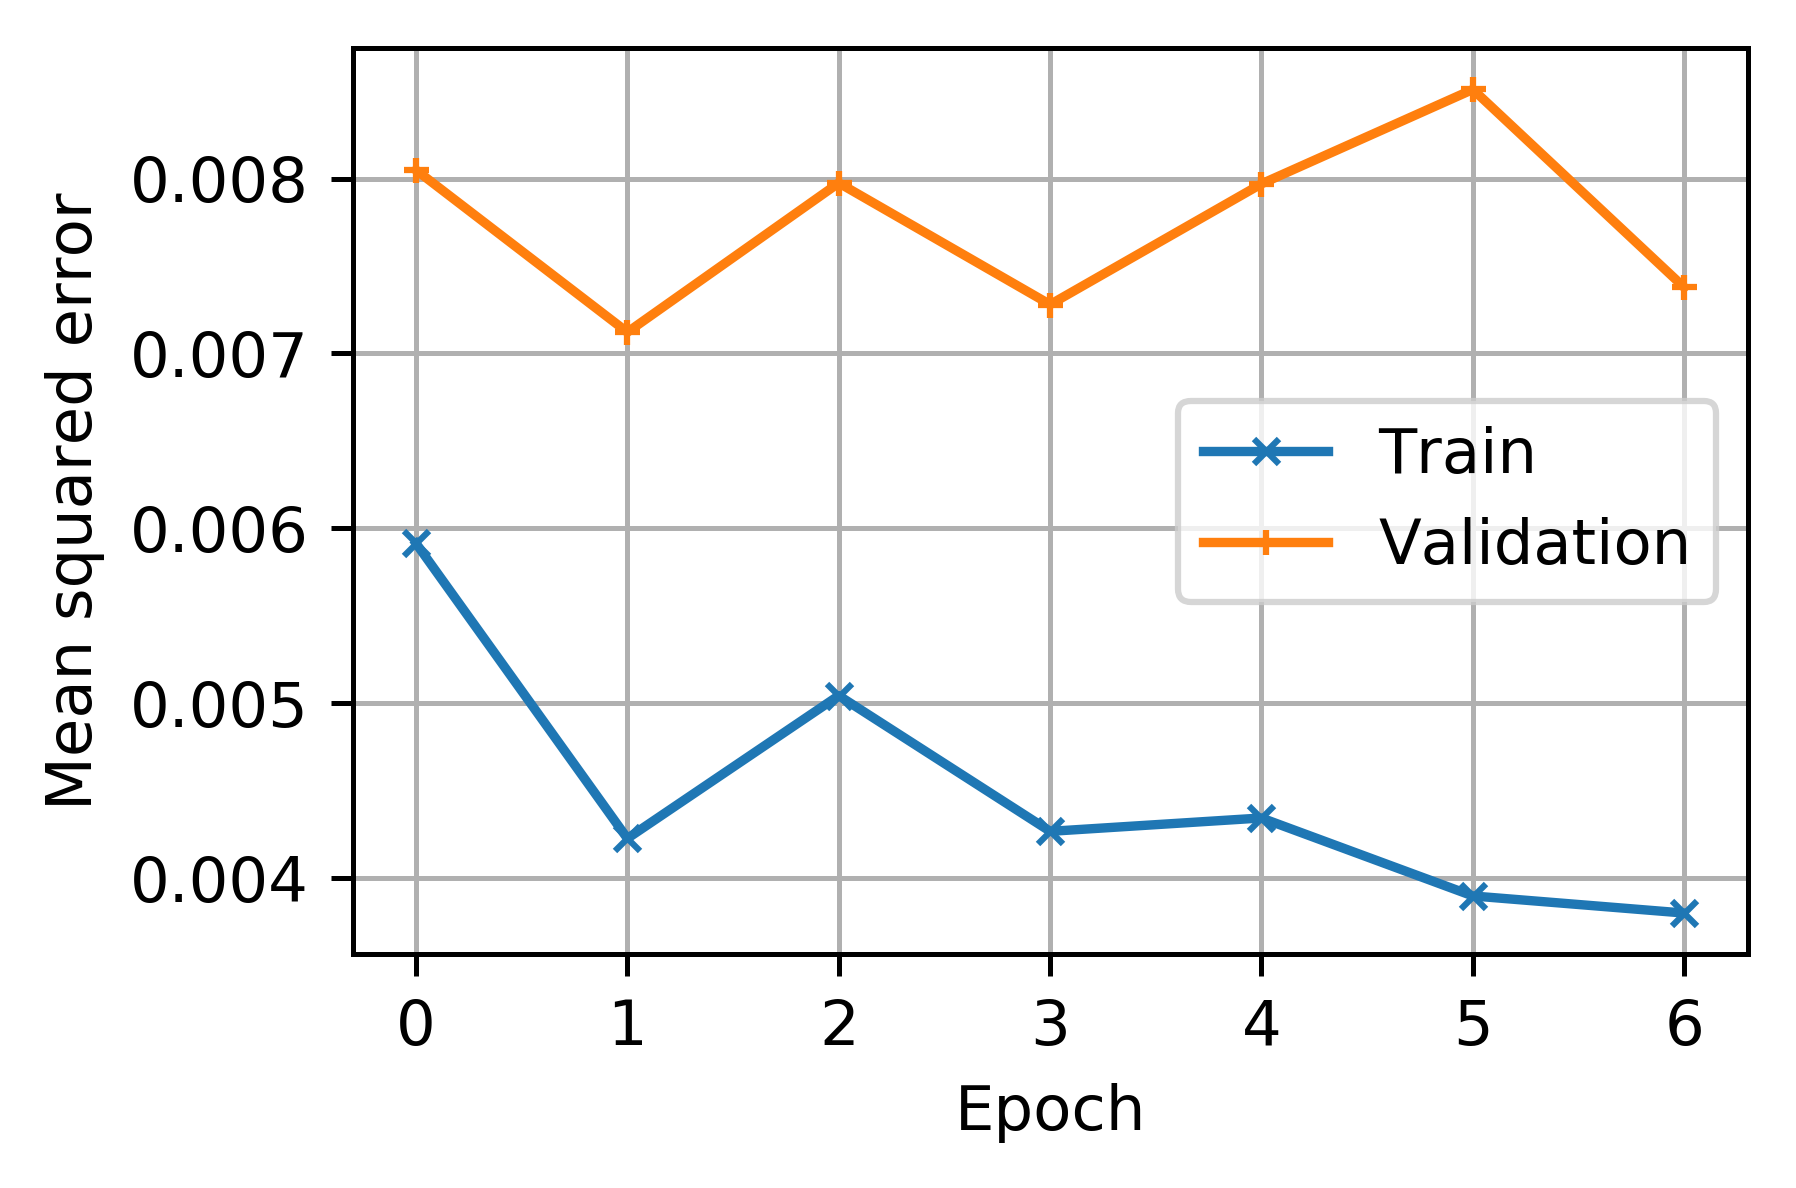

In [12]:
#Saving training history
np.save("../Data/loss_20190610-imagenet-fc_unet_cascade_fi_tf_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190610-imagenet-fc_unet_cascade_fi_tf_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# FI FC-U-net

In [13]:
epochs = 30
batch_size= 8
model_name = "../Models/20190607-imagenet-fc_unet_cascade_fi_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_fc_unet(depth_str='fi')
model.compile(loss = "mse",optimizer=opt)

0 f
Append DCT layer (patches)
Append FC/dense block
1 i
Append iDCT layer (patches)
Append U-net block


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 8, 8, 1)      0           input_2[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 64)           0           lambda_3[0][0]                   
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          8320        flatten_2[0][0]                  
__________________________________________________________________________________________________
dense_6 (D

In [15]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

No Data Consistency
Epoch 1/30
3750/3750 [==============================] - 407s 108ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 2/30
3750/3750 [==============================] - 402s 107ms/step - loss: 0.0041 - val_loss: 0.0086
Epoch 3/30
3750/3750 [==============================] - 401s 107ms/step - loss: 0.0037 - val_loss: 0.0070
Epoch 4/30
3750/3750 [==============================] - 402s 107ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 5/30
3750/3750 [==============================] - 401s 107ms/step - loss: 0.0035 - val_loss: 0.0067
Epoch 6/30
3750/3750 [==============================] - 401s 107ms/step - loss: 0.0034 - val_loss: 0.0066
Epoch 7/30
3750/3750 [==============================] - 401s 107ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 8/30
3750/3750 [==============================] - 401s 107ms/step - loss: 0.0033 - val_loss: 0.0066
Epoch 9/30
3750/3750 [==============================] - 401s 107ms/step - loss: 0.0033 - val_loss: 0.0065
Epoch 10/30
3750/3750 [===

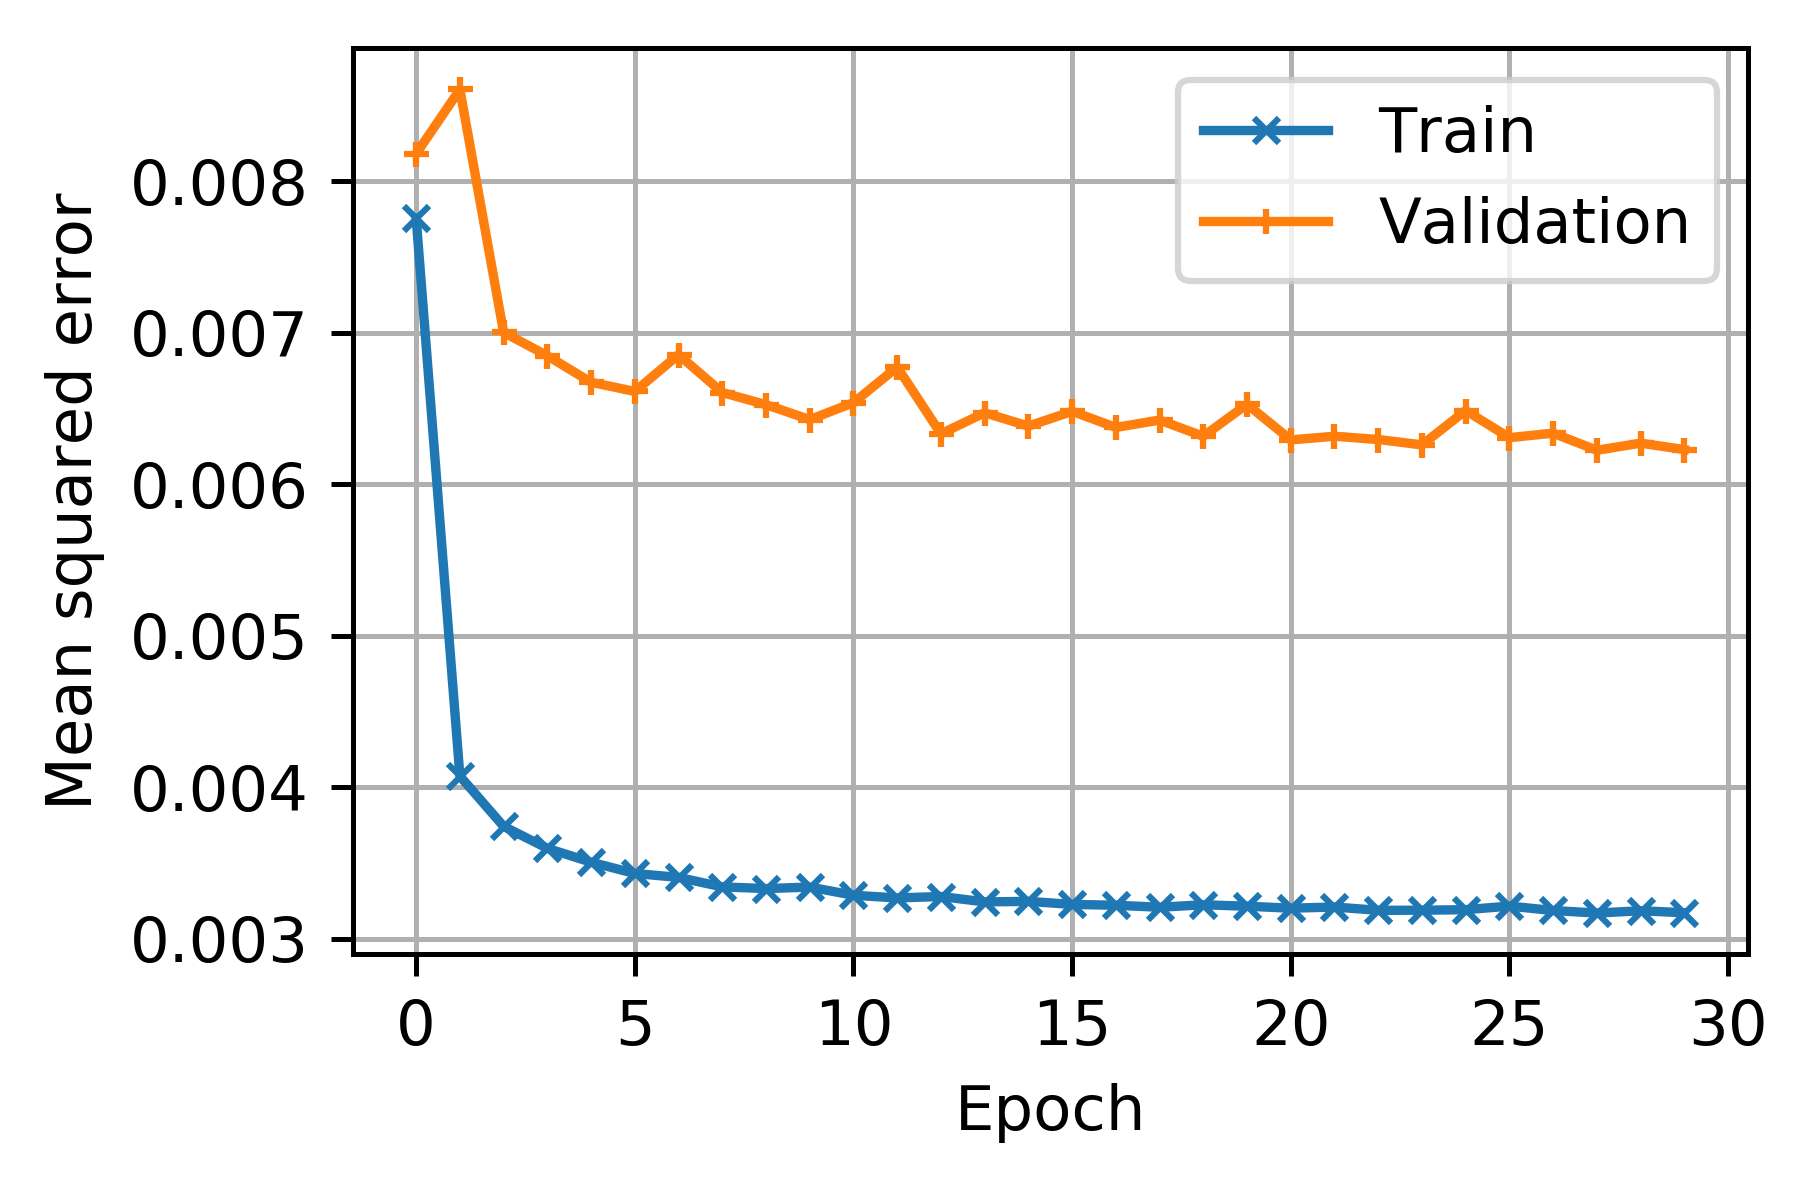

In [16]:
#Saving training history
np.save("../Data/loss_20190607-imagenet-fc_unet_cascade_fi_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190607-imagenet-fc_unet_cascade_fi_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# IF FC-U-net

In [17]:
epochs = 30
batch_size= 8
model_name = "../Models/20190607-imagenet-fc_unet_cascade_if_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_fc_unet(depth_str='if')
model.compile(loss = "mse",optimizer=opt)

0 i
Append U-net block
1 f
Append DCT layer (patches)
Append FC/dense block
Append iDCT layer (patches)


In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 48) 480         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 48) 20784       conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 48) 20784       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [19]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

No Data Consistency
Epoch 1/30
3750/3750 [==============================] - 437s 117ms/step - loss: 0.1910 - val_loss: 0.1955
Epoch 2/30
3750/3750 [==============================] - 434s 116ms/step - loss: 0.1901 - val_loss: 0.1954
Epoch 3/30
3750/3750 [==============================] - 434s 116ms/step - loss: 0.1898 - val_loss: 0.1952
Epoch 4/30
3750/3750 [==============================] - 434s 116ms/step - loss: 0.1898 - val_loss: 0.1951
Epoch 5/30
3750/3750 [==============================] - 434s 116ms/step - loss: 0.1896 - val_loss: 0.1958
Epoch 6/30
3750/3750 [==============================] - 435s 116ms/step - loss: 0.1896 - val_loss: 0.1950
Epoch 7/30
3750/3750 [==============================] - 434s 116ms/step - loss: 0.1877 - val_loss: 0.1902
Epoch 8/30
3750/3750 [==============================] - 434s 116ms/step - loss: 0.1843 - val_loss: 0.1899
Epoch 9/30
3750/3750 [==============================] - 434s 116ms/step - loss: 0.1843 - val_loss: 0.1898
Epoch 10/30
3750/3750 [===

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 434s 116ms/step - loss: 0.1843 - val_loss: 0.1896
Epoch 27/30
1989/3750 [==============>...............] - ETA: 2:56 - loss: 0.1839

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 431s 115ms/step - loss: 0.1843 - val_loss: 0.1896
Epoch 29/30
1414/3750 [==========>...................] - ETA: 3:52 - loss: 0.1857

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 431s 115ms/step - loss: 0.1841 - val_loss: 0.1895


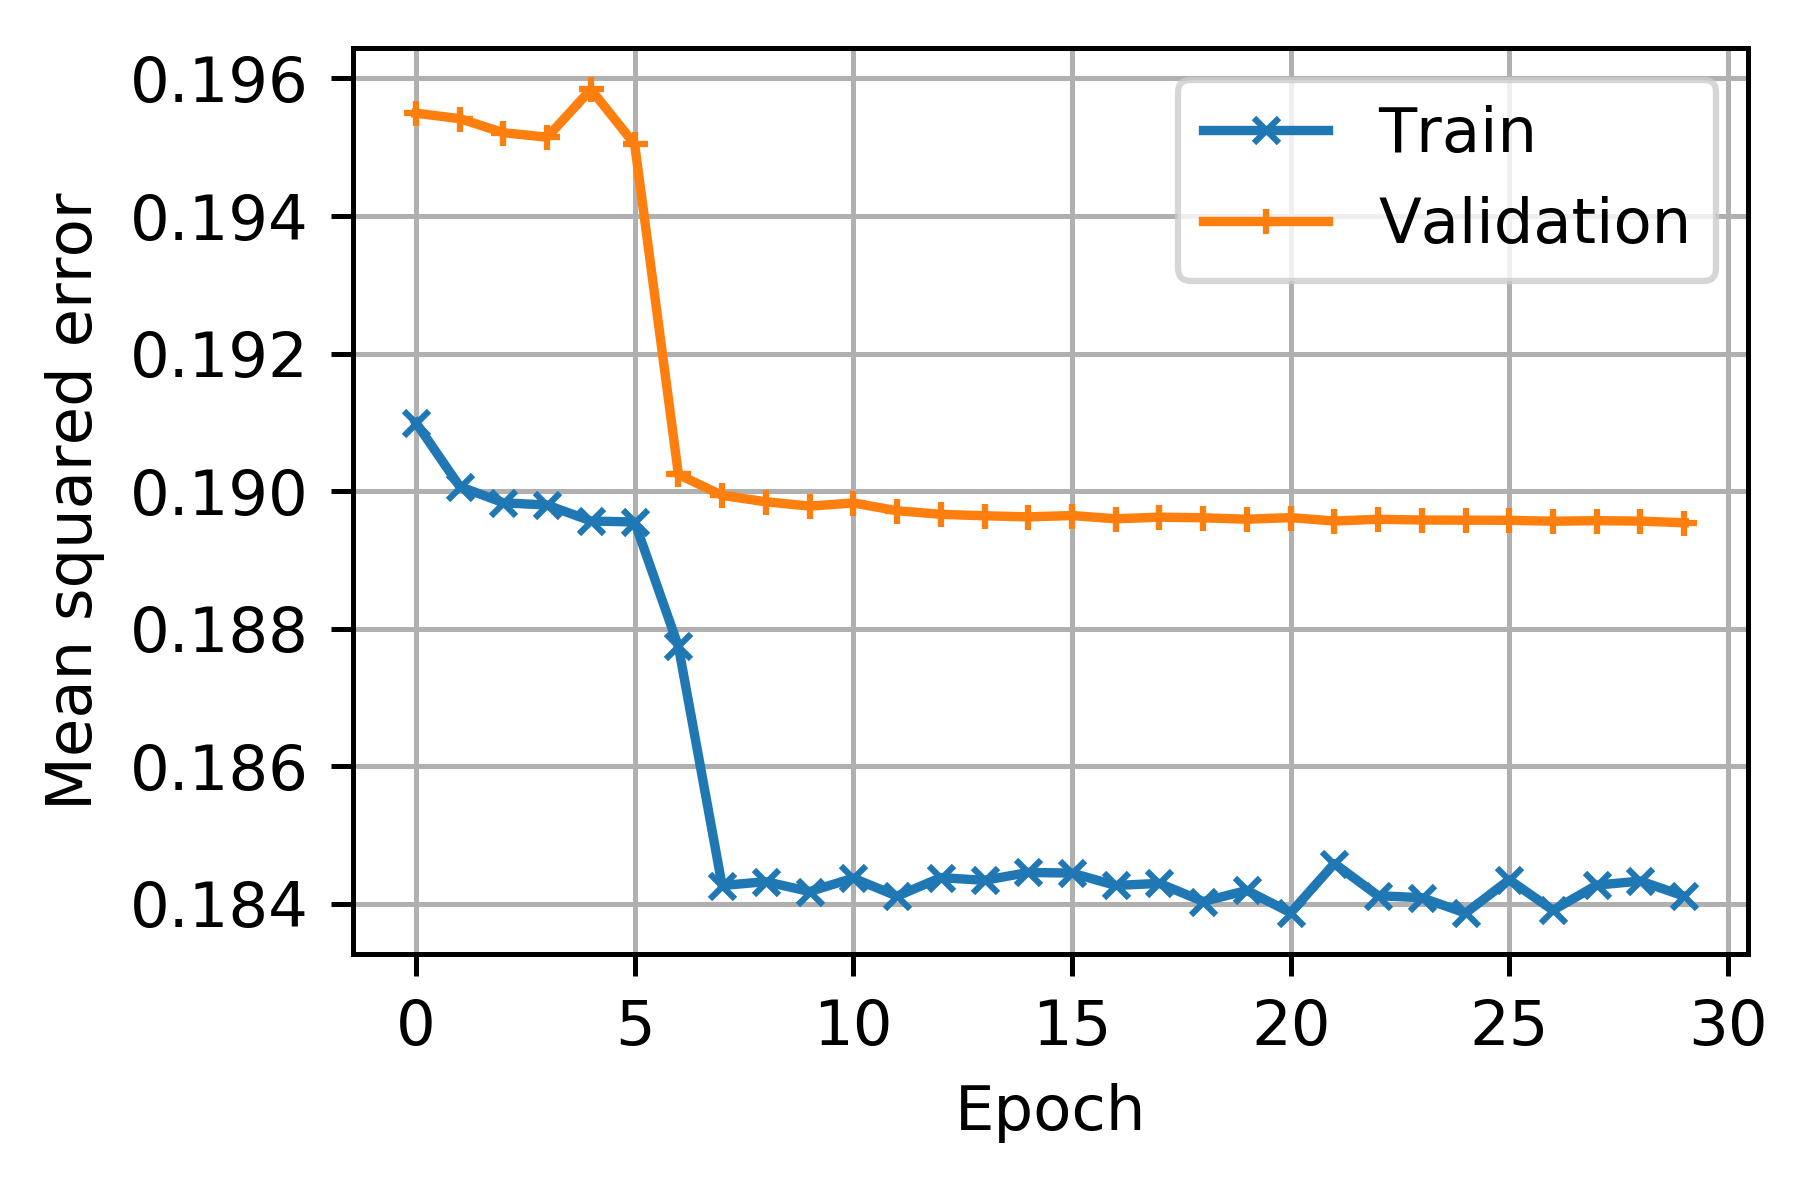

In [20]:
#Saving training history
np.save("../Data/loss_20190607-imagenet-fc_unet_cascade_if_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190607-imagenet-fc_unet_cascade_if_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# FF FC-U-net

In [21]:
epochs = 30
batch_size= 8
model_name = "../Models/20190607-imagenet-fc_unet_cascade_ff_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_fc_unet(depth_str='ff')
model.compile(loss = "mse",optimizer=opt)

0 f
Append DCT layer (patches)
Append FC/dense block
1 f
Append FC/dense block
Append iDCT layer (patches)


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 8, 8, 1)      0           input_4[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 64)           0           lambda_7[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 128)          8320        flatten_4[0][0]                  
__________________________________________________________________________________________________
dense_14 (

In [23]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

No Data Consistency
Epoch 1/30
3029/3750 [=======================>......] - ETA: 38s - loss: 0.2092

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3115/3750 [=======================>......] - ETA: 33s - loss: 0.2079

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 215s 57ms/step - loss: 0.2081 - val_loss: 0.2135
Epoch 5/30
2902/3750 [======================>.......] - ETA: 45s - loss: 0.2069

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 216s 58ms/step - loss: 0.2079 - val_loss: 0.2134
Epoch 7/30
2766/3750 [=====================>........] - ETA: 52s - loss: 0.2077

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 219s 58ms/step - loss: 0.2078 - val_loss: 0.2134
Epoch 9/30
2616/3750 [===================>..........] - ETA: 1:01 - loss: 0.2048

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 220s 59ms/step - loss: 0.2061 - val_loss: 0.2118
Epoch 11/30
2414/3750 [==================>...........] - ETA: 1:12 - loss: 0.2056

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 221s 59ms/step - loss: 0.2058 - val_loss: 0.2116
Epoch 13/30
2223/3750 [================>.............] - ETA: 1:22 - loss: 0.2060

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 222s 59ms/step - loss: 0.2060 - val_loss: 0.2117
Epoch 15/30
1976/3750 [==============>...............] - ETA: 1:36 - loss: 0.2047

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 220s 59ms/step - loss: 0.2059 - val_loss: 0.2116
Epoch 17/30
1784/3750 [=============>................] - ETA: 1:46 - loss: 0.2045

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 221s 59ms/step - loss: 0.2059 - val_loss: 0.2117
Epoch 19/30
1563/3750 [===========>..................] - ETA: 1:57 - loss: 0.2060

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 221s 59ms/step - loss: 0.2059 - val_loss: 0.2115
Epoch 21/30
1235/3750 [========>.....................] - ETA: 2:15 - loss: 0.2069

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 220s 59ms/step - loss: 0.2061 - val_loss: 0.2115
Epoch 23/30
1028/3750 [=======>......................] - ETA: 2:27 - loss: 0.2045

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 220s 59ms/step - loss: 0.2040 - val_loss: 0.2099
Epoch 25/30
 781/3750 [=====>........................] - ETA: 2:39 - loss: 0.2033

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 221s 59ms/step - loss: 0.2042 - val_loss: 0.2097
Epoch 27/30
 543/3750 [===>..........................] - ETA: 2:51 - loss: 0.2020

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 220s 59ms/step - loss: 0.2040 - val_loss: 0.2097
Epoch 28/30
1087/3750 [=======>......................] - ETA: 2:23 - loss: 0.2056

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 220s 59ms/step - loss: 0.2043 - val_loss: 0.2097
Epoch 29/30
 327/3750 [=>............................] - ETA: 2:59 - loss: 0.1990

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 220s 59ms/step - loss: 0.2038 - val_loss: 0.2097
Epoch 30/30
 848/3750 [=====>........................] - ETA: 2:36 - loss: 0.2069

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 221s 59ms/step - loss: 0.2044 - val_loss: 0.2099


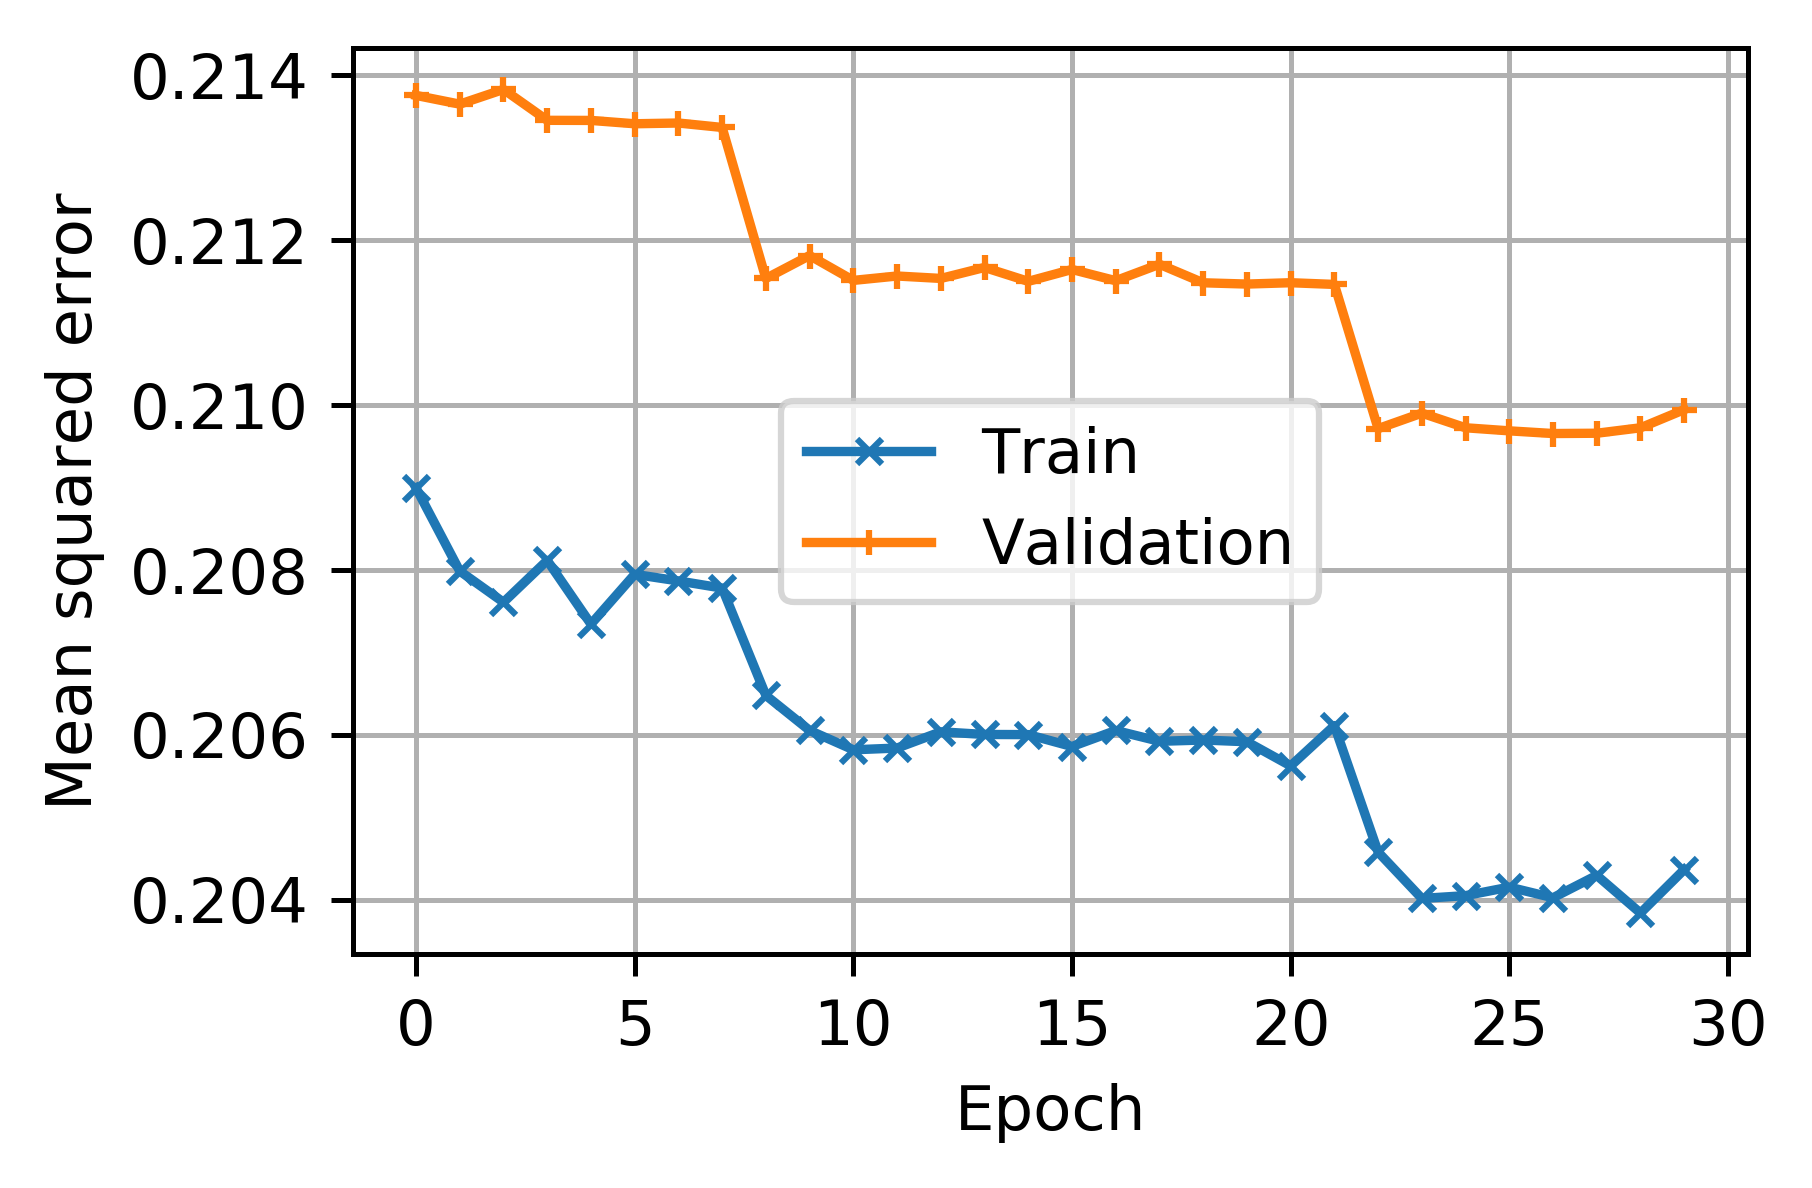

In [24]:
#Saving training history
np.save("../Data/loss_20190607-imagenet-fc_unet_cascade_ff_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190607-imagenet-fc_unet_cascade_ff_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# FIFI FC-U-net

In [25]:
epochs = 30
batch_size= 8
model_name = "../Models/20190607-imagenet-fc_unet_cascade_fifi_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_fc_unet(depth_str='fifi')
model.compile(loss = "mse",optimizer=opt)

0 f
Append DCT layer (patches)
Append FC/dense block
1 i
Append iDCT layer (patches)
Append U-net block
2 f
Append DCT layer (patches)
Append FC/dense block
3 i
Append iDCT layer (patches)
Append U-net block


In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 8, 8, 1)      0           input_5[0][0]                    
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 64)           0           lambda_9[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 128)          8320        flatten_6[0][0]                  
__________________________________________________________________________________________________
dense_22 (

In [27]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

No Data Consistency
Epoch 1/30
2998/3750 [======================>.......] - ETA: 2:24 - loss: 0.0091

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 821s 219ms/step - loss: 0.0048 - val_loss: 0.0084
Epoch 3/30
2792/3750 [=====================>........] - ETA: 3:01 - loss: 0.0041

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 820s 219ms/step - loss: 0.0046 - val_loss: 0.0091
Epoch 5/30
2517/3750 [===================>..........] - ETA: 3:52 - loss: 0.0042

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 818s 218ms/step - loss: 0.0039 - val_loss: 0.0073
Epoch 7/30
2248/3750 [================>.............] - ETA: 4:43 - loss: 0.0038

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 818s 218ms/step - loss: 0.0037 - val_loss: 0.0073
Epoch 9/30
1979/3750 [==============>...............] - ETA: 5:34 - loss: 0.0037

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 815s 217ms/step - loss: 0.0038 - val_loss: 0.0072
Epoch 11/30
1672/3750 [============>.................] - ETA: 6:30 - loss: 0.0038

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 814s 217ms/step - loss: 0.0036 - val_loss: 0.0072
Epoch 13/30
1405/3750 [==========>...................] - ETA: 7:19 - loss: 0.0036

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2568/3750 [===================>..........] - ETA: 3:41 - loss: 0.0035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1115/3750 [=======>......................] - ETA: 8:16 - loss: 0.0035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2289/3750 [=================>............] - ETA: 4:34 - loss: 0.0035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 859/3750 [=====>........................] - ETA: 9:02 - loss: 0.0035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 813s 217ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 18/30
2040/3750 [===============>..............] - ETA: 5:21 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 812s 216ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 19/30
 572/3750 [===>..........................] - ETA: 9:56 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 811s 216ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 20/30
1780/3750 [=============>................] - ETA: 6:09 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 812s 216ms/step - loss: 0.0034 - val_loss: 0.0072
Epoch 21/30
 310/3750 [=>............................] - ETA: 10:44 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 811s 216ms/step - loss: 0.0034 - val_loss: 0.0065
Epoch 22/30
1525/3750 [===========>..................] - ETA: 6:57 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 811s 216ms/step - loss: 0.0034 - val_loss: 0.0065
Epoch 23/30
  70/3750 [..............................] - ETA: 11:30 - loss: 0.0035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 811s 216ms/step - loss: 0.0034 - val_loss: 0.0068
Epoch 24/30
1244/3750 [========>.....................] - ETA: 7:52 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3449/3750 [==========================>...] - ETA: 56s - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 817s 218ms/step - loss: 0.0034 - val_loss: 0.0065
Epoch 26/30
 860/3750 [=====>........................] - ETA: 9:05 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3158/3750 [========================>.....] - ETA: 1:51 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 817s 218ms/step - loss: 0.0033 - val_loss: 0.0068
Epoch 28/30
 582/3750 [===>..........................] - ETA: 9:56 - loss: 0.0035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2880/3750 [======================>.......] - ETA: 2:44 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 817s 218ms/step - loss: 0.0034 - val_loss: 0.0064
Epoch 30/30
 334/3750 [=>............................] - ETA: 10:44 - loss: 0.0033

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2641/3750 [====================>.........] - ETA: 3:29 - loss: 0.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



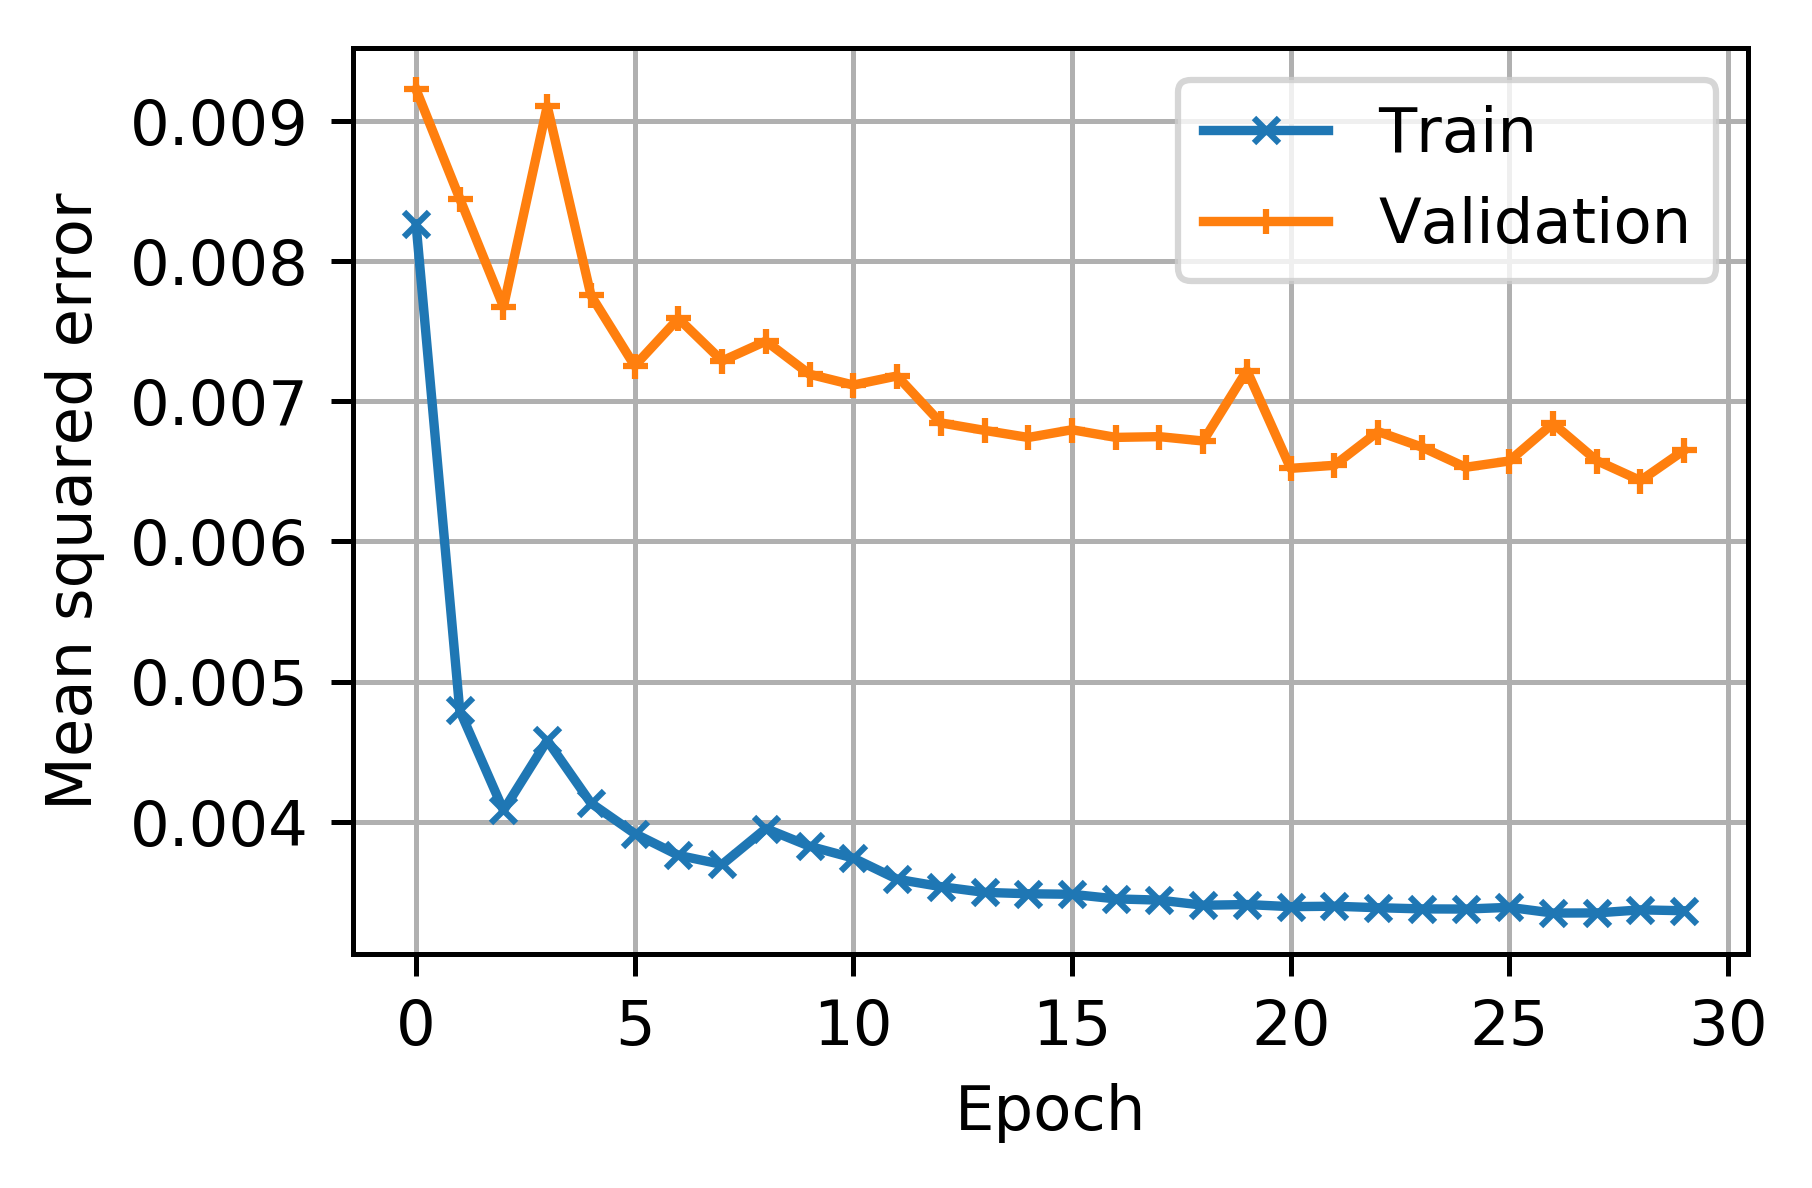

In [28]:
#Saving training history
np.save("../Data/loss_20190607-imagenet-fc_unet_cascade_fifi_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190607-imagenet-fc_unet_cascade_fifi_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# IFIF FC-U-net

In [29]:
epochs = 30
batch_size= 8
model_name = "../Models/20190607-imagenet-fc_unet_cascade_ifif_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_fc_unet(depth_str='ifif')
model.compile(loss = "mse",optimizer=opt)

0 i
Append U-net block
1 f
Append DCT layer (patches)
Append FC/dense block
2 i
Append iDCT layer (patches)
Append U-net block
3 f
Append DCT layer (patches)
Append FC/dense block
Append iDCT layer (patches)


In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 256, 256, 48) 480         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 256, 256, 48) 20784       conv2d_89[0][0]                  
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 256, 256, 48) 20784       conv2d_90[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [31]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

No Data Consistency
Epoch 1/30
2993/3750 [======================>.......] - ETA: 2:30 - loss: 0.2024

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 844s 225ms/step - loss: 0.2085 - val_loss: 0.2136
Epoch 3/30
2692/3750 [====================>.........] - ETA: 3:26 - loss: 0.2062

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 842s 224ms/step - loss: 0.2009 - val_loss: 0.2063
Epoch 5/30
2432/3750 [==================>...........] - ETA: 4:16 - loss: 0.2007

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2142/3750 [================>.............] - ETA: 5:12 - loss: 0.2001

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2165/3750 [================>.............] - ETA: 5:08 - loss: 0.1978

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1892/3750 [==============>...............] - ETA: 6:01 - loss: 0.1985

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 841s 224ms/step - loss: 0.1978 - val_loss: 0.2029
Epoch 9/30
1897/3750 [==============>...............] - ETA: 6:00 - loss: 0.1970

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1606/3750 [===========>..................] - ETA: 6:54 - loss: 0.1953

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 836s 223ms/step - loss: 0.1971 - val_loss: 0.2024
Epoch 11/30
1626/3750 [============>.................] - ETA: 6:51 - loss: 0.1983

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1362/3750 [=========>....................] - ETA: 7:42 - loss: 0.1955

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 837s 223ms/step - loss: 0.1956 - val_loss: 0.2006
Epoch 13/30
1370/3750 [=========>....................] - ETA: 7:40 - loss: 0.1947

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1074/3750 [=======>......................] - ETA: 8:39 - loss: 0.1975

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 835s 223ms/step - loss: 0.1952 - val_loss: 0.2007
Epoch 15/30
1094/3750 [=======>......................] - ETA: 8:33 - loss: 0.1963

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 835s 223ms/step - loss: 0.1950 - val_loss: 0.2007
Epoch 16/30
 769/3750 [=====>........................] - ETA: 9:37 - loss: 0.1956

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 836s 223ms/step - loss: 0.1953 - val_loss: 0.2007
Epoch 17/30
 735/3750 [====>.........................] - ETA: 9:42 - loss: 0.1949

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 836s 223ms/step - loss: 0.1950 - val_loss: 0.2007
Epoch 18/30
 460/3750 [==>...........................] - ETA: 10:35 - loss: 0.1984

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 836s 223ms/step - loss: 0.1950 - val_loss: 0.2007
Epoch 19/30
 456/3750 [==>...........................] - ETA: 10:35 - loss: 0.1987

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 833s 222ms/step - loss: 0.1951 - val_loss: 0.2006
Epoch 20/30
 159/3750 [>.............................] - ETA: 11:32 - loss: 0.1924

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 832s 222ms/step - loss: 0.1949 - val_loss: 0.2006
Epoch 21/30
 175/3750 [>.............................] - ETA: 11:31 - loss: 0.2001

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3623/3750 [===========================>..] - ETA: 24s - loss: 0.1953

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3604/3750 [===========================>..] - ETA: 28s - loss: 0.1950

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3298/3750 [=========================>....] - ETA: 1:28 - loss: 0.1944

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3323/3750 [=========================>....] - ETA: 1:23 - loss: 0.1947

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3036/3750 [=======================>......] - ETA: 2:19 - loss: 0.1949

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3076/3750 [=======================>......] - ETA: 2:11 - loss: 0.1942

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2744/3750 [====================>.........] - ETA: 3:15 - loss: 0.1957

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2769/3750 [=====================>........] - ETA: 3:11 - loss: 0.1949

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2486/3750 [==================>...........] - ETA: 4:06 - loss: 0.1957

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2538/3750 [===================>..........] - ETA: 3:56 - loss: 0.1940

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



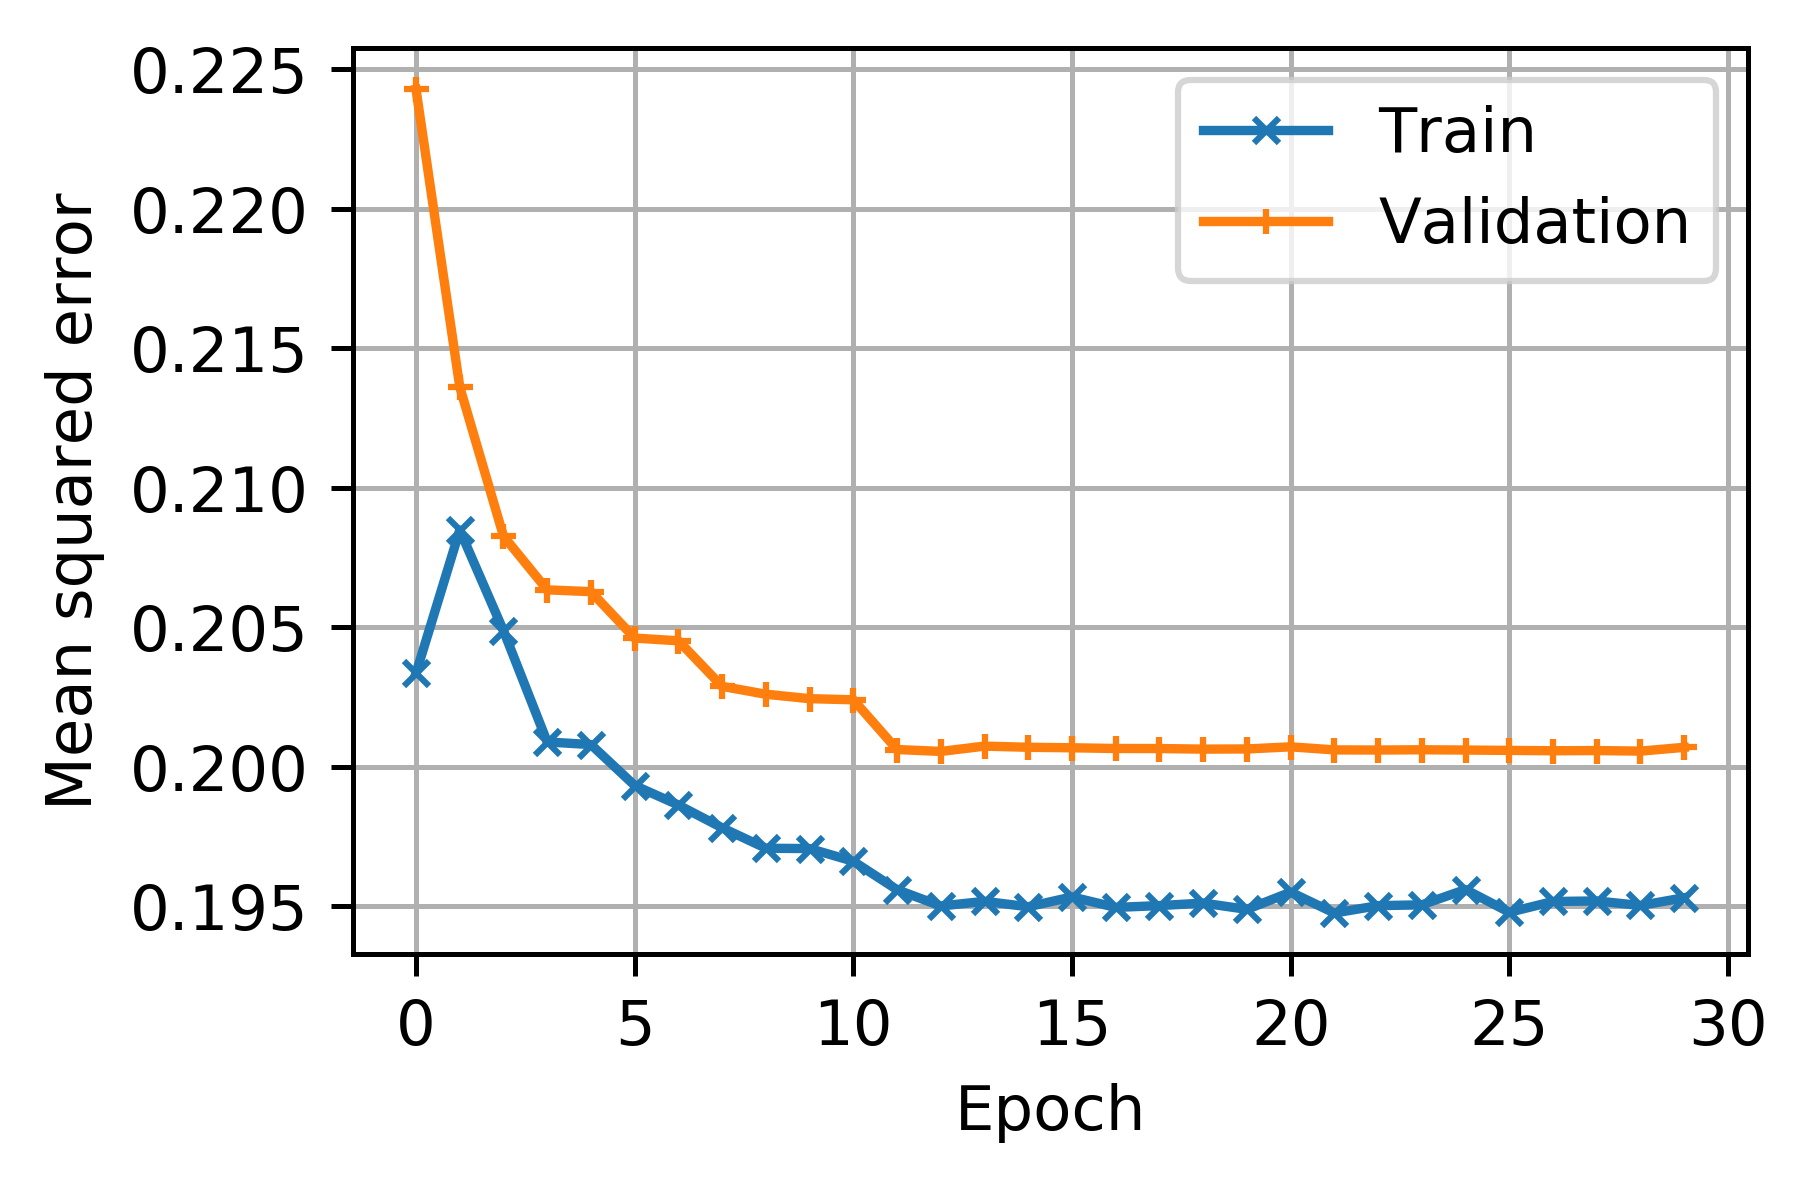

In [32]:
#Saving training history
np.save("../Data/loss_20190607-imagenet-fc_unet_cascade_ifif_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190607-imagenet-fc_unet_cascade_ifif_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =========================================================
<a name='networkg'/>

# Network G: Fully-Connected Network

In [33]:
# DCT of validation set

val_unc_pat = extract_image_patches(val_unc, patch_size = 8)
val_compr_pat = extract_image_patches(val_compr, patch_size = 8)

dct_val_unc = np.zeros(val_unc_pat.shape)
dct_val_compr = np.zeros(val_unc_pat.shape)

for ii in range(len(val_unc_pat)):
    dct_val_unc[ii,:,:,0] = py_dct2d(val_unc_pat[ii,:,:,0])
    dct_val_compr[ii,:,:,0] = py_dct2d(val_compr_pat[ii,:,:,0])

print(dct_val_unc.shape)
print(dct_val_compr.shape)

(15360000, 8, 8, 1)
(15360000, 8, 8, 1)


In [34]:
epochs = 30
batch_size= 8
model_name = "../Models/20190606-imagenet-fc_f_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

opt = Adam(lr=0.001)

model = dequantization_network()
    
model.compile(loss = "mse",optimizer=opt)

In [35]:
# free some memory
val_unc = 0
val_compr = 0
val_unc_pat = 0
val_compr_pat = 0

In [36]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

#train_qmat = np.zeros((len(train_images),H,W,1),dtype = np.float32)

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)
                               
        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
            batch_unc_pat = extract_image_patches(batch_unc, patch_size = 8)
            batch_comp_pat = extract_image_patches(batch_comp, patch_size = 8)
            
            dct_batch_unc = batch_unc_pat.copy()
            dct_batch_comp = batch_comp_pat.copy()
            
            for jj in range(len(batch_unc_pat)):
                dct_batch_unc[jj,:,:,0] = py_dct2d((batch_unc_pat[jj,:,:,0] - norm)/norm)
                dct_batch_comp[jj,:,:,0] = py_dct2d((batch_comp_pat[jj,:,:,0] - norm)/norm)
            
        yield(dct_batch_comp, dct_batch_unc)

combined = combine_generator(image_generator1,compr_range)

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 8, 8, 1)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
reshape_10 (Reshape)         (None, 8, 8, 1)           0         
Total para

In [38]:
print("No Data Consistency\n")
hist = model.fit_generator(combined,
             epochs=epochs,
             steps_per_epoch=train_unc.shape[0] / batch_size,
             verbose=1,
             validation_data= (dct_val_compr,dct_val_unc),
             callbacks=[checkpoint,earlyStopping])

No Data Consistency

Epoch 1/30
2999/3750 [======================>.......] - ETA: 39:22 - loss: 0.1800

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3577/3750 [===========================>..] - ETA: 8:57 - loss: 0.1790

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2754/3750 [=====================>........] - ETA: 51:47 - loss: 0.1780

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3313/3750 [=========================>....] - ETA: 22:59 - loss: 0.1790

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2464/3750 [==================>...........] - ETA: 1:08:18 - loss: 0.1790

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3053/3750 [=======================>......] - ETA: 35:45 - loss: 0.1786

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2217/3750 [================>.............] - ETA: 1:21:11 - loss: 0.1794

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2778/3750 [=====================>........] - ETA: 50:22 - loss: 0.1793

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1920/3750 [==============>...............] - ETA: 1:34:33 - loss: 0.1795

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2513/3750 [===================>..........] - ETA: 1:05:38 - loss: 0.1798

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3750/3750 [==============================] - 11816s 3s/step - loss: 0.1787 - val_loss: 0.1848
Epoch 11/30
1337/3750 [=========>....................] - ETA: 2:04:16 - loss: 0.1781

KeyboardInterrupt: 

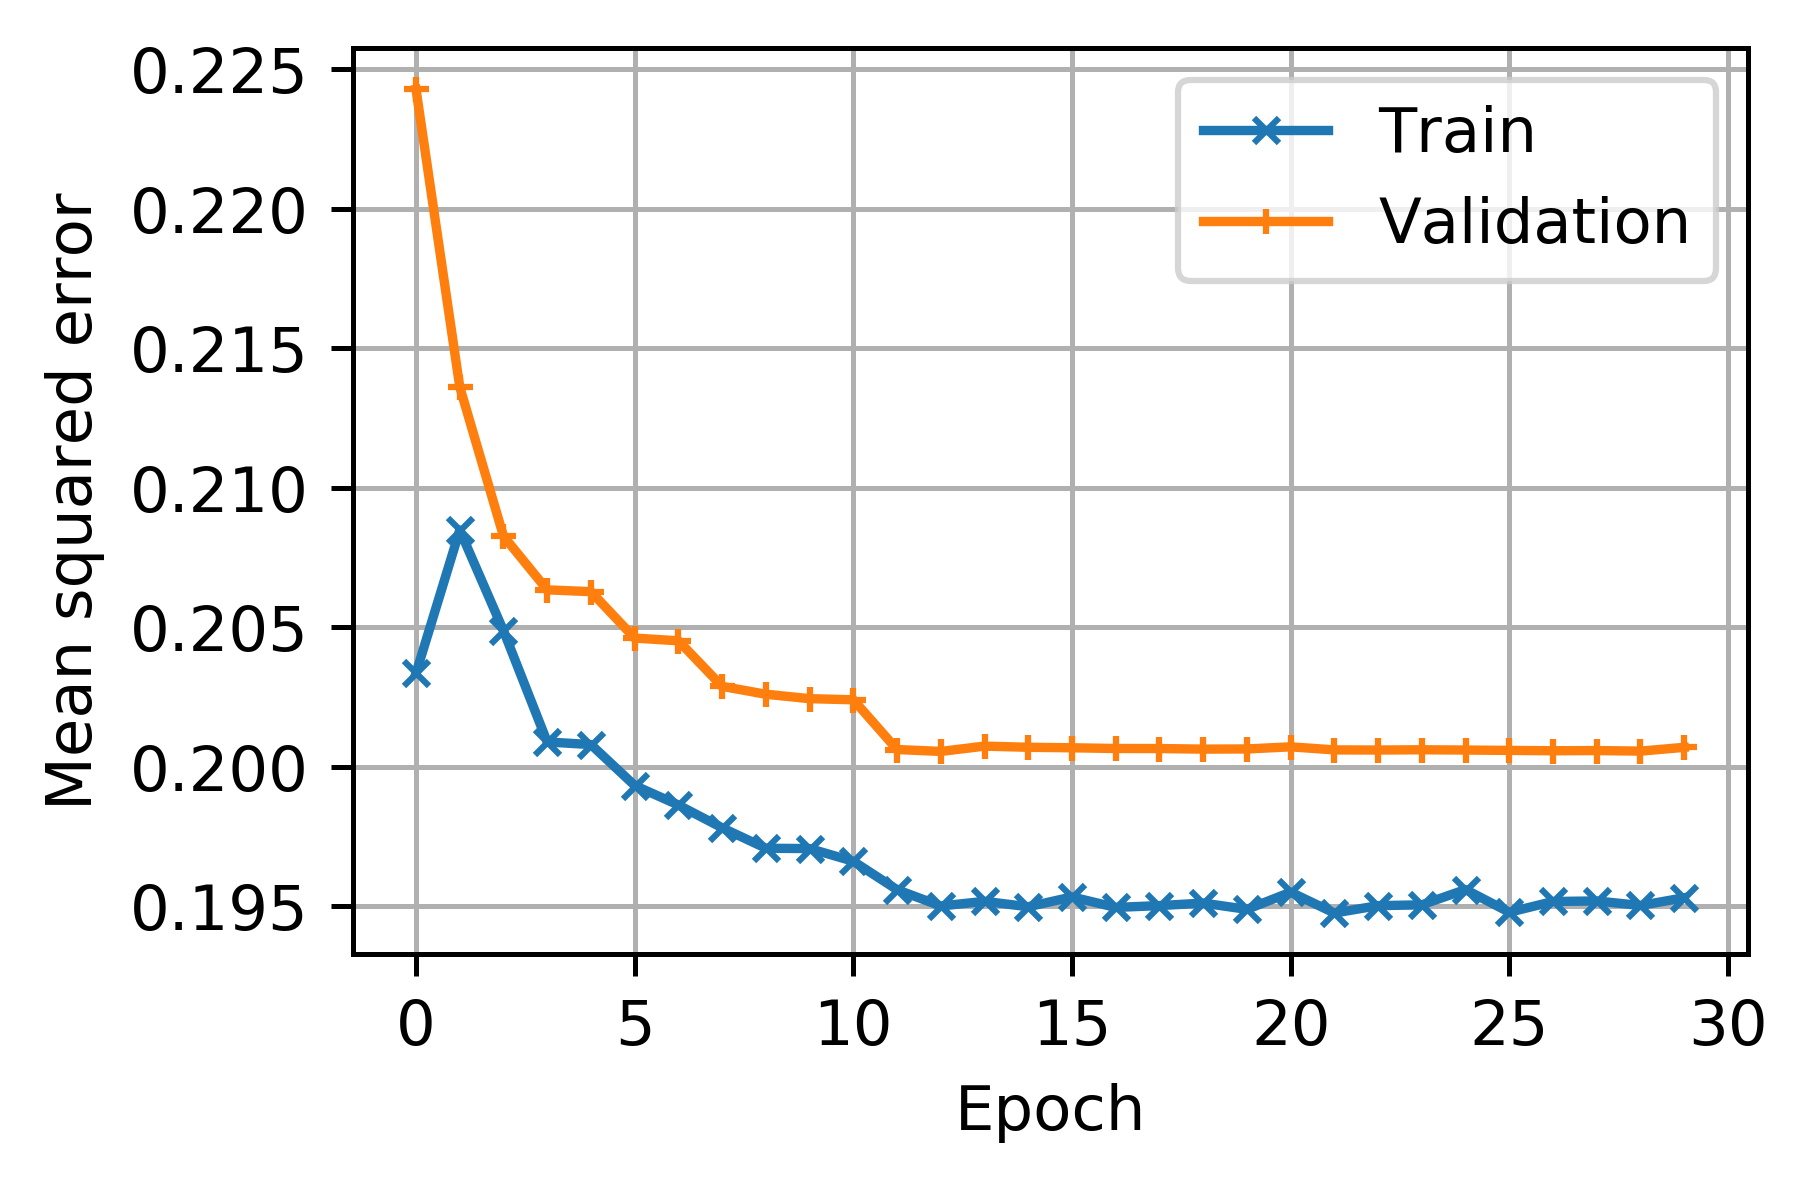

In [39]:
#Saving training history
np.save("../Data/loss_20190606-imagenet-fc_f_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190606-imagenet-fc_f_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
adfs12 as123dfa

# =========================================================

# DFT U-net

In [14]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
# train_images = images[0:30000]
# val_images = images[30000:45000]
# test_images = images[45000:]
train_images = images[0:15000]
val_images = images[30000:37500]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

48624
Train set size: 15000
Validation set size: 7500
Test set size: 3624


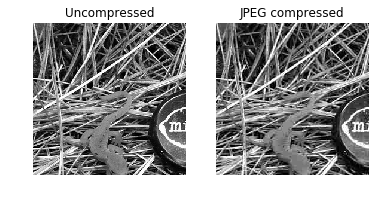

In [15]:
# Load uncompressed image
im1 = Image.open(train_images[50])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [17]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

useDC = False

# need two channels
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
#val_qmat = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
    # val_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
        
val_unc -= 128.0
val_unc /= 128.0

val_compr -= 128.0
val_compr /= 128.0

val_unc /= norm
val_compr /= norm

#val_qmat /= 255.0

(7500, 256, 256, 1)
-0.003921569 0.0038909314 -0.001105245
-0.003921569 0.0038909314 -0.0011025752


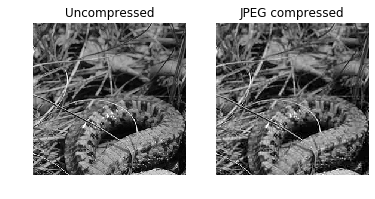

In [18]:
nn = 10

print(val_unc.shape)
print(val_unc[nn,:,:,0].min(),val_unc[nn,:,:,0].max(), val_unc[nn,:,:,0].mean())
print(val_compr[nn,:,:,0].min(),val_compr[nn,:,:,0].max(), val_compr[nn,:,:,0].mean())

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(val_unc[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(val_compr[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [19]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?
batch_size= 8
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

#train_qmat = np.zeros((len(train_images),H,W,1),dtype = np.float32)

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator_no_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
#             batch_comp /= norm
#             batch_unc /= norm
            
        yield(np.concatenate(((batch_comp-128.0)/128.0,np.zeros(batch_comp.shape)), axis=3),\
              np.concatenate(((batch_unc-128.0)/128.0,np.zeros(batch_unc.shape)), axis=3))
            
        #yield((batch_comp - norm)/norm, (batch_unc - norm)/norm)
#         yield(batch_comp/norm, batch_unc/norm) #not centering values around 0
        
def combine_generator_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            train_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
            
        #yield([(batch_comp - 128.0)/128.0, train_qmat/255.0], (batch_unc-128.0)/128.0)
        yield([(batch_comp - 128.0), train_qmat], (batch_unc-128.0))

# combine generators into one which yields image and masks
if useDC:
    combined = combine_generator_dc(image_generator1,compr_range)
else:
    combined = combine_generator_no_dc(image_generator1,compr_range)

(8, 256, 256, 2) (8, 256, 256, 2)
-1.0 0.9921875
-1.0 0.9921875
-0.9998250007629395 0.9921875


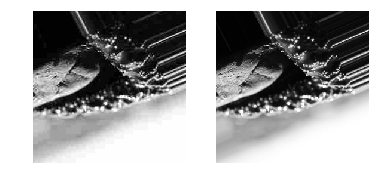

In [20]:
# sample data augmentation
if useDC:
    for ii in combined:
        print(ii[0][0].shape)
        print(ii[0][0].min(),ii[0][0].max(), ii[0][0].mean())
        print(ii[1].min(),ii[1].max(), ii[1].mean())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break
else:
    for ii in combined:
        print(ii[0].shape, ii[1].shape)
        print(ii[0].min(),ii[0].max())
        print(ii[1].min(),ii[1].max())
        print(ii[1][2,:,:,0].min(),ii[1][2,:,:,0].max())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break

In [21]:
# Concatenate an imaginary channel of 0s
val_unc = np.concatenate((val_unc,np.zeros(val_unc.shape)), axis=3)
val_compr = np.concatenate((val_compr,np.zeros(val_compr.shape)), axis=3)

In [22]:
print(val_unc.shape)
print(val_compr.shape)

(7500, 256, 256, 2)
(7500, 256, 256, 2)


In [35]:
epochs = 100
model_name = "../Models/20190610-imagenet-residual_wnet_nodc_ki_patches_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=5, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'ki'

opt = Adam(lr=0.001)

if useDC:
    model = deep_cascade_unet_ksp_patches_no_dc(depth_str) # not implemented
else:
    model = deep_cascade_unet_ksp_patches_no_dc(depth_str)
    
model.compile(loss = "mse",optimizer=opt)

NameError: name 'deep_cascade_unet_ksp_patches_no_dc' is not defined

In [ ]:
if useDC:
    print("Use Data Consistency\n")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency\n")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_20190606-imagenet-residual_wnet_nodc_k_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190606-imagenet-residual_wnet_nodc_k_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# KK W-net

In [ ]:
epochs = 30
model_name = "../Models/20190606-imagenet-residual_wnet_nodc_kk_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'kk'

opt = Adam(lr=0.001)

if useDC:
    model = deep_cascade_unet_ksp_no_dc(depth_str) # not implemented
else:
    model = deep_cascade_unet_ksp_no_dc(depth_str)
    
model.compile(loss = "mse",optimizer=opt)

In [ ]:
if useDC:
    print("Use Data Consistency\n")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency\n")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_20190606-imagenet-residual_wnet_nodc_kk_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190606-imagenet-residual_wnet_nodc_kk_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# KKKK WW-net

In [ ]:
epochs = 30
model_name = "../Models/20190606-imagenet-residual_wnet_nodc_kkkk_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'kkkk'

opt = Adam(lr=0.001)

if useDC:
    model = deep_cascade_unet_ksp_no_dc(depth_str) # not implemented
else:
    model = deep_cascade_unet_ksp_no_dc(depth_str)
    
model.compile(loss = "mse",optimizer=opt)

In [ ]:
if useDC:
    print("Use Data Consistency\n")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency\n")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_20190606-imagenet-residual_wnet_nodc_kkkk_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190606-imagenet-residual_wnet_nodc_kkkk_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# IK W-net

In [ ]:
epochs = 30
model_name = "../Models/20190606-imagenet-residual_wnet_nodc_ik_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'ik'

opt = Adam(lr=0.001)

if useDC:
    model = deep_cascade_unet_ksp_no_dc(depth_str) # not implemented
else:
    model = deep_cascade_unet_ksp_no_dc(depth_str)
    
model.compile(loss = "mse",optimizer=opt)

In [ ]:
if useDC:
    print("Use Data Consistency\n")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency\n")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_20190606-imagenet-residual_wnet_nodc_ik_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190606-imagenet-residual_wnet_nodc_ik_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# KIKI WW-net

In [ ]:
epochs = 30
model_name = "../Models/20190606-imagenet-residual_wnet_nodc_kiki_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'kiki'

opt = Adam(lr=0.001)

if useDC:
    model = deep_cascade_unet_ksp_no_dc(depth_str) # not implemented
else:
    model = deep_cascade_unet_ksp_no_dc(depth_str)
    
model.compile(loss = "mse",optimizer=opt)

In [ ]:
if useDC:
    print("Use Data Consistency\n")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency\n")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_20190606-imagenet-residual_wnet_nodc_kiki_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190606-imagenet-residual_wnet_nodc_kiki_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# IKIK WW-net

In [ ]:
epochs = 30
model_name = "../Models/20190606-imagenet-residual_wnet_nodc_ikik_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'ikik'

opt = Adam(lr=0.001)

if useDC:
    model = deep_cascade_unet_ksp_no_dc(depth_str) # not implemented
else:
    model = deep_cascade_unet_ksp_no_dc(depth_str)
    
model.compile(loss = "mse",optimizer=opt)

In [ ]:
if useDC:
    print("Use Data Consistency\n")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency\n")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_20190606-imagenet-residual_wnet_nodc_ikik_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190606-imagenet-residual_wnet_nodc_ikik_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
stop
aopfkakope =1o0p190

# =========================================================
<a name='networkf'/>

# Network F: DFT-Image W-net

In [3]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
# train_images = images[0:30000]
# val_images = images[30000:45000]
# test_images = images[45000:]
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

48624
Train set size: 30000
Validation set size: 15000
Test set size: 3624


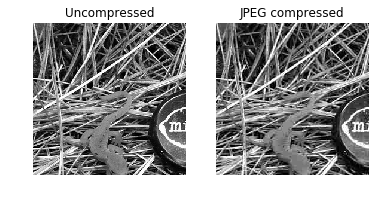

In [4]:
# Load uncompressed image
im1 = Image.open(train_images[50])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [6]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

epochs = 100
batch_size= 8

useDC = True

# need two channels
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_qmat = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
    val_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
        
val_unc -= 128.0
val_unc /= 128.0

val_compr -= 128.0
val_compr /= 128.0

#val_unc /= norm
#val_compr /= norm

val_qmat /= 128.0

(15000, 256, 256, 1)
-1.0 0.9921875 -0.28183746
-1.0 0.9921875 -0.2802577


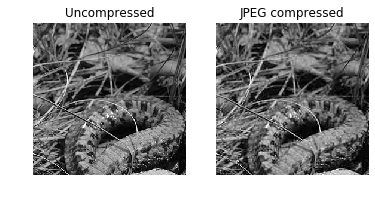

In [7]:
nn = 10

print(val_unc.shape)
print(val_unc[nn,:,:,0].min(),val_unc[nn,:,:,0].max(), val_unc[nn,:,:,0].mean())
print(val_compr[nn,:,:,0].min(),val_compr[nn,:,:,0].max(), val_compr[nn,:,:,0].mean())

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(val_unc[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(val_compr[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [8]:
# Data augmentation
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

#train_qmat = np.zeros((len(train_images),H,W,1),dtype = np.float32)

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator_no_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
#             batch_comp /= norm
#             batch_unc /= norm
            
        yield(np.concatenate((batch_comp/255.0,np.zeros(batch_comp.shape)), axis=3),\
              np.concatenate((batch_unc/255.0,np.zeros(batch_unc.shape)), axis=3))
            
        #yield((batch_comp - norm)/norm, (batch_unc - norm)/norm)
#         yield(batch_comp/norm, batch_unc/norm) #not centering values around 0
        
def combine_generator_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            train_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
            
        #yield([(batch_comp - 128.0)/128.0, train_qmat/255.0], (batch_unc-128.0)/128.0)
        yield([(batch_comp - 128.0)/128.0, train_qmat/128.0], [(batch_unc-128.0)/128.0,(batch_unc-128.0)/128.0])

# combine generators into one which yields image and masks
if useDC:
    combined = combine_generator_dc(image_generator1,compr_range)
else:
    combined = combine_generator_no_dc(image_generator1,compr_range)

In [8]:
# sample data augmentation
if useDC:
    for ii in combined:
        print(ii[0][0].shape)
        print(ii[0][0].min(),ii[0][0].max(), ii[0][0].mean())
        print(ii[1].min(),ii[1].max(), ii[1].mean())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break
else:
    for ii in combined:
        print(ii[0][0].shape, ii[1][0].shape)
        print(ii[0][0].min(),ii[0][0].max())
        print(ii[1][0].min(),ii[1][0].max())
        print(ii[1][0][2,:,:,0].min(),ii[1][0][2,:,:,0].max())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break

(8, 256, 256, 1)
-1.0 0.9921875 -0.06354782


AttributeError: 'list' object has no attribute 'min'

In [ ]:
# Concatenate an imaginary channel of 0s
# val_unc = np.concatenate((val_unc,np.zeros(val_unc.shape)), axis=3)
# val_compr = np.concatenate((val_compr,np.zeros(val_compr.shape)), axis=3)

In [9]:
print(val_unc.shape)
print(val_compr.shape)

(15000, 256, 256, 1)
(15000, 256, 256, 1)


In [9]:
model_name = "../Models/20190611-imagenet-residual_wnet_k_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=10, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'k'

opt = Adam(lr=0.001)

if useDC:
     model = deep_cascade_unet_rksp(depth_str)
    #model = deep_cascade_unet_ksp_no_dc(depth_str)
else:
    model = deep_cascade_unet_ksp_no_dc(depth_str)
    
model.compile(loss = "mse",optimizer=opt,loss_weights=[0.6,0.4])

Instructions for updating:
Colocations handled automatically by placer.
0 k
Append rFFT layer
Append U-net (2-channel) block
Append iFFT layer
Append magnitude layer
Append data consistency layer (DCT-DC-iDCT)
Instructions for updating:
Use tf.cast instead.


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 48) 912         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 48) 20784       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
if useDC:
    print("Use Data Consistency\n")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],[val_unc, val_unc]),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency\n")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Use Data Consistency

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2830/3750 [=====================>........] - ETA: 1:34 - loss: 0.2080 - lambda_16_loss: 0.1727 - lambda_9_loss: 0.2609

In [ ]:
#Saving training history
np.save("../Data/loss_20190611-imagenet-residual_wnet_patches_ki_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190611-imagenet-residual_wnet_patches_ki_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =========================================================

# =========================================================

# =========================================================
<a name='networka'/>

# Network A: Image-domain U-net

In [ ]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

In [ ]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
H,W = 256, 256
norm = 255.0
compr_range = (15,16)

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
        
val_unc -= 128.0
val_unc /= 128.0

val_compr -= 128.0
val_compr /= 128.0

In [ ]:
num_network = 1

epochs = 30
batch_size= 8
model_name = "../Models/single_qf/20190405-imagenet-residual_unet_i_data_augmentation_compress_15.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'i'

opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        dct_batch_unc = batch_unc.copy()
        dct_batch_comp = batch_comp.copy()
        
        if compr_range[0] != compr_range[1]:
            compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)
        else:
            compr = np.zeros(batch_unc.shape[0]) + compr_range[0] # note: compr is a float

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield(batch_comp, batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/single_qf/loss_20190405-imagenet-residual_unet_i_data_augmentation_compress_15.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_20190405-imagenet-residual_unet_i_data_augmentation_compress_15.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkb'/>

# Network B: DCT-domain U-net

In [ ]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

In [ ]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
H,W = 256, 256
norm = 255.0
compr_range = (15,16)

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

dct_train_unc = train_unc.copy()
dct_train_compr = train_unc.copy()
dct_val_unc = val_unc.copy()
dct_val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
        
val_unc -= 128.0
val_unc /= 128.0

val_compr -= 128.0
val_compr /= 128.0

In [ ]:
# DCT of validation set

for ii in range(len(val_images)):
    dct_val_unc[ii,:,:,0] = dct_in_blocks(val_unc[ii,:,:,0])
    dct_val_compr[ii,:,:,0] = dct_in_blocks(val_compr[ii,:,:,0])

In [ ]:
num_network = 1

epochs = 30
batch_size= 8
model_name = "../Models/single_qf/20190405-imagenet-residual_unet_d_data_augmentation_compress_15.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'i'

opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        dct_batch_unc = batch_unc.copy()
        dct_batch_comp = batch_comp.copy()
        
        if compr_range[0] != compr_range[1]:
            compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)
        else:
            compr = np.zeros(batch_unc.shape[0]) + compr_range[0] # note: compr is a float

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)

            dct_batch_unc[ii,:,:,0] = dct_in_blocks((batch_unc[ii,:,:,0].astype(np.float32)-128.0)/128.0)
            dct_batch_comp[ii,:,:,0] = dct_in_blocks((batch_comp[ii,:,:,0]-128.0)/128.0)
            
        yield(dct_batch_comp, dct_batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (dct_val_compr,dct_val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/single_qf/loss_20190405-imagenet-residual_unet_d_data_augmentation_compress_15.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_20190405-imagenet-residual_unet_d_data_augmentation_compress_15.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkc'/>

# Network C: DCT-Image W-net

In [ ]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

In [ ]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

useDC = True

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_qmat = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
    val_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
        
val_unc -= 128.0
#val_unc /= 128.0

val_compr -= 128.0
#val_compr /= 128.0

#val_qmat /= 255.0

In [ ]:
nn = 5910

print(val_unc.shape)
print(val_unc[nn,:,:,0].min(),val_unc[nn,:,:,0].max(), val_unc[nn,:,:,0].mean())
print(val_compr[nn,:,:,0].min(),val_compr[nn,:,:,0].max(), val_compr[nn,:,:,0].mean())

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(val_unc[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(val_compr[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
num_network = 3

epochs = 30
batch_size= 8
model_name = "../Models/20190426-imagenet-residual_wnet_dc_di_data_augmentation_compress_10_20-2.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'i'

opt = Adam(lr=0.001)

if useDC:
    model = deep_cascade_unet(depth_str)
else:
    model = deep_cascade_unet_no_dc(depth_str)
        
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

#train_qmat = np.zeros((len(train_images),H,W,1),dtype = np.float32)

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator_no_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield((batch_comp - 128.0)/128.0, (batch_unc-128.0)/128.0)
        
def combine_generator_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            train_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
            
        #yield([(batch_comp - 128.0)/128.0, train_qmat/255.0], (batch_unc-128.0)/128.0)
        yield([(batch_comp - 128.0), train_qmat], (batch_unc-128.0))

# combine generators into one which yields image and masks
if useDC:
    combined = combine_generator_dc(image_generator1,compr_range)
else:
    combined = combine_generator_no_dc(image_generator1,compr_range)

In [ ]:
# sample data augmentation
if useDC:
    for ii in combined:
        print(ii[0][0].shape)
        print(ii[0][0].min(),ii[0][0].max(), ii[0][0].mean())
        print(ii[1].min(),ii[1].max(), ii[1].mean())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break
else:
    for ii in combined:
        print(ii[0].shape)
        print(ii[0].min(),ii[0].max(), ii[0].mean())
        print(ii[1].min(),ii[1].max(), ii[1].mean())
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.show()
        break

In [ ]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],val_unc),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/single_qf/loss_20190426-imagenet-residual_wnet_di_data_augmentation_compress_10_20-2.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_20190426-imagenet-residual_wnet_di_data_augmentation_compress_10_20-2.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkc2'/>

# Network C2: Pseudo DCT-Image W-net

In [ ]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

In [ ]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
H,W = 256, 256
norm = 255.0
compr_range = (15,16)

loadFromFile = True
useNoise = False

pseudo_train_path = "../np_imagedata/single_qf/train_20190405-imagenet-residual_unet_d_data_augmentation_compress_15_2019-04-07-imagenet.npy"
pseudo_val_path = "../np_imagedata/single_qf/val_20190405-imagenet-residual_unet_d_data_augmentation_compress_15_2019-04-07-imagenet.npy"

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
compr_train = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
    
#     if loadFromFile:
#         im2 = Image.open(train_images[ii])
#         train_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
#     else:
    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_train[ii]))
    im2 = Image.open(buf)
    train_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

#     if loadFromFile:
#         # JPEG compress the image
#         im2 = Image.open(val_images[ii])
#         val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
#     else:
    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
        

if loadFromFile:
    train_compr = np.load(pseudo_train_path)
    val_compr = np.load(pseudo_val_path)

if useNoise:
    for ii in range(len(train_images)):
        train_compr[ii,:,:,0] = train_compr[ii,:,:,0] + \
        np.random.normal(train_compr[ii,:,:,0].mean(), train_compr[ii,:,:,0].std(), train_compr[ii,:,:,0].shape)
    for ii in range(len(val_images)):
        val_compr[ii,:,:,0] = val_compr[ii,:,:,0] + \
        np.random.normal(val_compr[ii,:,:,0].mean(), val_compr[ii,:,:,0].std(), val_compr[ii,:,:,0].shape)

train_unc -= 128.0
train_unc /= 128.0

train_compr -= 128.0
train_compr /= 128.0
        
val_unc -= 128.0
val_unc /= 128.0

val_compr -= 128.0
val_compr /= 128.0

In [ ]:
num_network = 3

epochs = 30
batch_size= 8
model_name = "../Models/single_qf/20190407-imagenet-residual_pseudo_wnet_i_data_augmentation_compress_15.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'i'

opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# seed = 905
# image_datagen1 = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.075,
#         height_shift_range=0.075,
#         shear_range=0.25,
#         zoom_range=0.25,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='nearest')

# image_datagen1.fit(train_unc, augment=True, seed=seed)

# image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

# def combine_generator(gen1,compr_range, loadFromFile):
#     while True:
#         batch_unc = gen1.next()
#         batch_comp = np.zeros_like(batch_unc)

        
#         for ii in range(batch_unc.shape[0]):
#             # JPEG compress the image    
#             im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
#             buffer = io.BytesIO()
#             im1.save(buffer, "JPEG", quality=int(compr_range[ii]))
#             im2 = Image.open(buffer)
#             batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
#         yield((batch_comp-128.0)/128.0, (batch_unc.astype(np.float32)-128.0)/128.0)

# # combine generators into one which yields image and masks
# combined = combine_generator(image_generator1,compr_range)

batch_size= 8
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(train_compr,batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2):
    while True:
        batch_unc = gen1.next()
        batch_comp = gen2.next()
        
        yield(batch_comp, batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/single_qf/loss_20190407-imagenet-residual_pseudo_wnet_i_data_augmentation_compress_15.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_20190407-imagenet-residual_pseudo_wnet_i_data_augmentation_compress_15..npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkd'/>

# Network D: Image-Image-domain W-net

In [ ]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

In [ ]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
H,W = 256, 256
norm = 255.0
compr_range = (15,16)

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
        
val_unc -= 128.0
val_unc /= 128.0

val_compr -= 128.0
val_compr /= 128.0

In [ ]:
num_network = 4

epochs = 30
batch_size= 8
model_name = "../Models/single_qf/20190405-imagenet-residual_wnet_ii_data_augmentation_compress_15.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'i'

opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        dct_batch_unc = batch_unc.copy()
        dct_batch_comp = batch_comp.copy()
        
        if compr_range[0] != compr_range[1]:
            compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)
        else:
            compr = np.zeros(batch_unc.shape[0]) + compr_range[0] # note: compr is a float

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield(batch_comp, batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/single_qf/loss_20190405-imagenet-residual_unet_i_data_augmentation_compress_15.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_20190405-imagenet-residual_unet_i_data_augmentation_compress_15.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networke'/>

# Network E: DCT-DCT-domain W-net

In [ ]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

In [ ]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
H,W = 256, 256
norm = 255.0
compr_range = (15,16)

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

dct_train_unc = train_unc.copy()
dct_train_compr = train_unc.copy()
dct_val_unc = val_unc.copy()
dct_val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
        
val_unc -= 128.0
val_unc /= 128.0

val_compr -= 128.0
val_compr /= 128.0

In [ ]:
# DCT of validation set

for ii in range(len(val_images)):
    dct_val_unc[ii,:,:,0] = dct_in_blocks(val_unc[ii,:,:,0])
    dct_val_compr[ii,:,:,0] = dct_in_blocks(val_compr[ii,:,:,0])

In [ ]:
num_network = 4

epochs = 30
batch_size= 8
model_name = "../Models/single_qf/20190405-imagenet-residual_wnet_dd_data_augmentation_compress_15.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'i'

opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        dct_batch_unc = batch_unc.copy()
        dct_batch_comp = batch_comp.copy()
        
        if compr_range[0] != compr_range[1]:
            compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)
        else:
            compr = np.zeros(batch_unc.shape[0]) + compr_range[0] # note: compr is a float

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)

            dct_batch_unc[ii,:,:,0] = dct_in_blocks((batch_unc[ii,:,:,0].astype(np.float32)-128.0)/128.0)
            dct_batch_comp[ii,:,:,0] = dct_in_blocks((batch_comp[ii,:,:,0]-128.0)/128.0)
            
        yield(dct_batch_comp, dct_batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (dct_val_compr,dct_val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/single_qf/loss_20190405-imagenet-residual_wnet_dd_data_augmentation_compress_15.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_20190405-imagenet-residual_wnet_dd_data_augmentation_compress_15.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# ================================================================

# =============================================================
<a name='scratchpad'/>

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_dd_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='dd')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_wnet_dd_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_dd_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_ii_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='ii')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_wnet_ii_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_ii_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_d_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='d')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_d_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_d_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_i_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='i')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_i_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_i_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
from scipy.fftpack import dct as DCT, idct as IDCT

def py_dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def py_idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = py_dct2d(block)

    return dct_matrix

def tf_dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = py_idct2d(block)

    return im_matrix


In [ ]:
from keras import backend as K
def tf_dct2d(im):
    return K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))
    
    
def tf_idct2d(mat):
    return K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(mat,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))


# Modified from:
# https://stackoverflow.com/questions/44047753/reconstructing-an-image-after-using-extract-image-patches
def extract_patches(x):
    return K.tf.extract_image_patches(
        x,
        (1, 8, 8, 1),
        (1, 8, 8, 1),
        (1, 1, 1, 1),
        padding="SAME"
    )


def extract_patches_inverse(x, y):
    _x = K.tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = K.tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return K.tf.gradients(_y, _x, grad_ys=y)[0] / grad


In [ ]:
# Testing stuff
length = 3

tens = np.zeros((length, 256,256,1), dtype=np.float32)
for ii in range(length):
    im1 = Image.open(train_images[ii*150])
    im1_array = np.array(im1)
    
    tens[ii,:,:,0] = im1_array
    
patches = extract_patches(tens)
dct_patches = tf_dct2d(patches)
tf_dct_image = extract_patches_inverse(tens, dct_patches)

dct_patches_2 = extract_patches(tf_dct_image)
img_patches = tf_idct2d(dct_patches_2)
tf_image = extract_patches_inverse(tens,img_patches)

np_tf_dct_image = tf_eval(tf_dct_image)
np_tf_image = tf_eval(tf_image)

for ii in range(length):
    plt.figure(figsize=(18,9))
    plt.subplot(length,3,3*ii+1)
    plt.imshow(tens[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Original Image")
    plt.subplot(length,3,3*ii+2)
    plt.imshow(np_tf_dct_image[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
    plt.axis("off")
    plt.title("TF DCT")
    plt.subplot(length,3,3*ii+3)
    plt.imshow(np_tf_image[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("TF IDCT")
plt.show()

In [ ]:
# Testing stuff
length = 3

tens = np.zeros((length, 256,256,1), dtype=np.float32)
for ii in range(length):
    im1 = Image.open(train_images[ii*150])
    im1_array = np.array(im1)
    
    tens[ii,:,:,0] = im1_array

py_dct_img = py_dct2d(im1_array)
tf_dct_img = K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im1_array,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))

py_img = py_idct2d(py_dct_img)
tf_img = K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(tf_dct_img,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))

plt.figure(figsize=(18,9))
plt.subplot(length,3,1)
plt.imshow(tf_eval(tf_dct_img),cmap = "gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("TF DCT")
plt.subplot(length,3,2)
plt.imshow(py_dct_img,cmap = "gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("PY DCT")
plt.subplot(length,3,4)
plt.imshow(tf_eval(tf_img),cmap = "gray")
plt.axis("off")
plt.title("TF IDCT")
plt.subplot(length,3,5)
plt.imshow(py_img,cmap = "gray")
plt.axis("off")
plt.title("PY IDCT")
plt.show()

mse = ((py_dct_img - tf_eval(tf_dct_img))**2).mean(axis=None)

print("TF DCT: ", np.mean(tf_eval(tf_dct_img)), np.min(tf_eval(tf_dct_img)), np.max(tf_eval(tf_dct_img)))
print("PY DCT: ", np.mean(py_dct_img), np.min(py_dct_img), np.max(py_dct_img))
print("TF IDCT: ", np.mean(tf_eval(tf_img)), np.min(tf_eval(tf_img)), np.max(tf_eval(tf_img)))
print("PY IDCT: ", np.mean(py_img), np.min(py_img), np.max(py_img))
#print(py_dct_img == tf_eval(tf_dct_img))
print(mse)

# py_dct_image = tens.copy()
# tf_dct_image = tens.copy()
# for ii in range(length):
#     py_dct_image[ii,:,:,0] = py_dct2d(tens[ii,:,:,0])
#     tf_dct_image[ii,:,:,0] = tf_dct2d(tens[ii,:,:,0])

# # py_dct_image = tens.copy()
# # tf_dct_image = tens.copy()
# # for ii in range(length):
# #     py_dct_image[ii,:,:,0] = dct_in_blocks(tens[ii,:,:,0])
# #     tf_dct_image = tf_dct_in_blocks(tens[ii,:,:,0])


# # patches = extract_patches(tens)
# # dct_patches = dct2d(patches)
# # tf_dct_image = extract_patches_inverse(tens, dct_patches)

# print(tf_dct_image.eval)
# test = tf_eval(tf_dct_image)
# # Display the images
# plt.figure(figsize=(18,9))
# for ii in range(length):
#     plt.subplot(length,3,3*ii+1)
#     plt.imshow(tens[ii,:,:,0],cmap = "gray")
#     plt.axis("off")
#     plt.title("Uncompressed")
#     plt.subplot(length,3,3*ii+2)
#     plt.imshow(py_dct_image[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
#     plt.axis("off")
#     plt.title("Python DCT")
#     plt.subplot(length,3,3*ii+3)
#     plt.imshow(test[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
#     plt.axis("off")
#     plt.title("TF DCT")
# plt.show()